<a href="https://colab.research.google.com/github/Harvey-MSKim/MPC-Project---Trajectory-Generation-Using-MPC-For-High-Speed-Overtaking/blob/main/MPC_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MPC for Multi-Agent Control

Final Project


In [1]:
# This cell is commented out because Polytope package, Pyomo and solvers are already installed on Docker image.
# Please run this cell only if you are using Google Colab. 

# install required dependencies
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install polytope
  !pip install -q pyomo
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64

     |████████████████████████████████| 51 kB 2.7 MB/s 
  Created wheel for polytope: filename=polytope-0.2.3-py3-none-any.whl size=46059 sha256=d3f3d73d46344ac5a336790dce926f8c2df0732e650219ca923b5c3b76f46335
  Stored in directory: /root/.cache/pip/wheels/22/52/02/b0f1baef4767ba74a977b80fff80ea7aff9a5d6468b3c1a900
Successfully built polytope
     |████████████████████████████████| 9.2 MB 4.8 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Un

In [5]:
import polytope as pt
import numpy as np
from __future__ import division
import pyomo.environ as pyo
import matplotlib.pyplot as plt

def minkowski_sum(X, Y):

    # Minkowski sum between two polytopes based on 
    # vertex enumeration. So, it's not fast for the
    # high dimensional polytopes with lots of vertices.
    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        V1 = X
        
    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])
                    
    return pt.qhull(np.asarray(V_sum))

def pontryagin_diff(X, Y):
    
    # X, Y should have the same dimenson
    # X - Y
    m, n = X.A.shape
    H = [] 
    for i in range(X.A.shape[0]):
        x = cp.Variable(n)
        prob = cp.Problem( cp.Maximize(X.A[i, :] @ x), [Y.A @ x <= Y.b] )
        prob.solve()
        H.append(prob.value)
        
    H = np.reshape(np.asarray(H), (len(H), 1))
        
    return pt.Polytope(X.A, X.b - H)

def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([]), Wset=pt.Polytope()):
    
    if not B.any():
        if not pt.is_empty(Wset):
            return pt.Polytope( pontryagin_diff(Xset, Wset).A @ A, Xset.b)
        else:
            return pt.Polytope(Xset.A @ A, Xset.b)
        
    if not pt.is_empty(Wset):
        tmp  = minkowski_sum( pontryagin_diff(Xset, Wset), pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)
    else:
        tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)

def successor(Xset, A, Uset=pt.Polytope(), B=np.array([]), Wset=pt.Polytope()):
    
    # Xset, Uset shoud be polytope
    # print(Xset)
    # print(A)
    # print(Uset)
    # print(B)
    # autonomous case: xdot = Ax
    if not B.any():
        if not pt.is_empty(Wset):
            return minkowski_sum(pt.qhull(pt.extreme(Xset) @ A.T), Wset)
        else:
            return pt.qhull(pt.extreme(Xset) @ A.T)
    
    # controlled case: xdot = Ax+Bu
    if not pt.is_empty(Wset):
        return minkowski_sum(minkowski_sum(pt.extreme(Xset) @ A.T, 
                                           pt.extreme(Uset) @ B.T), Wset)
    else:
        return minkowski_sum(pt.extreme(Xset) @ A.T, 
                     pt.extreme(Uset) @ B.T)

def Oinf(Xset, A, Wset=pt.Polytope()):
    
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = precursor(Omega, A, Wset=Wset).intersect(Omega)
        else:
            Omegap = precursor(Omega, A).intersect(Omega)
    return Omegap

def Cinf(Xset, A, Uset, B, Wset=pt.Polytope()):
    
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = precursor(Omega, A, Uset, B, Wset=Wset).intersect(Omega)
        else:
            Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    return Omegap


<center>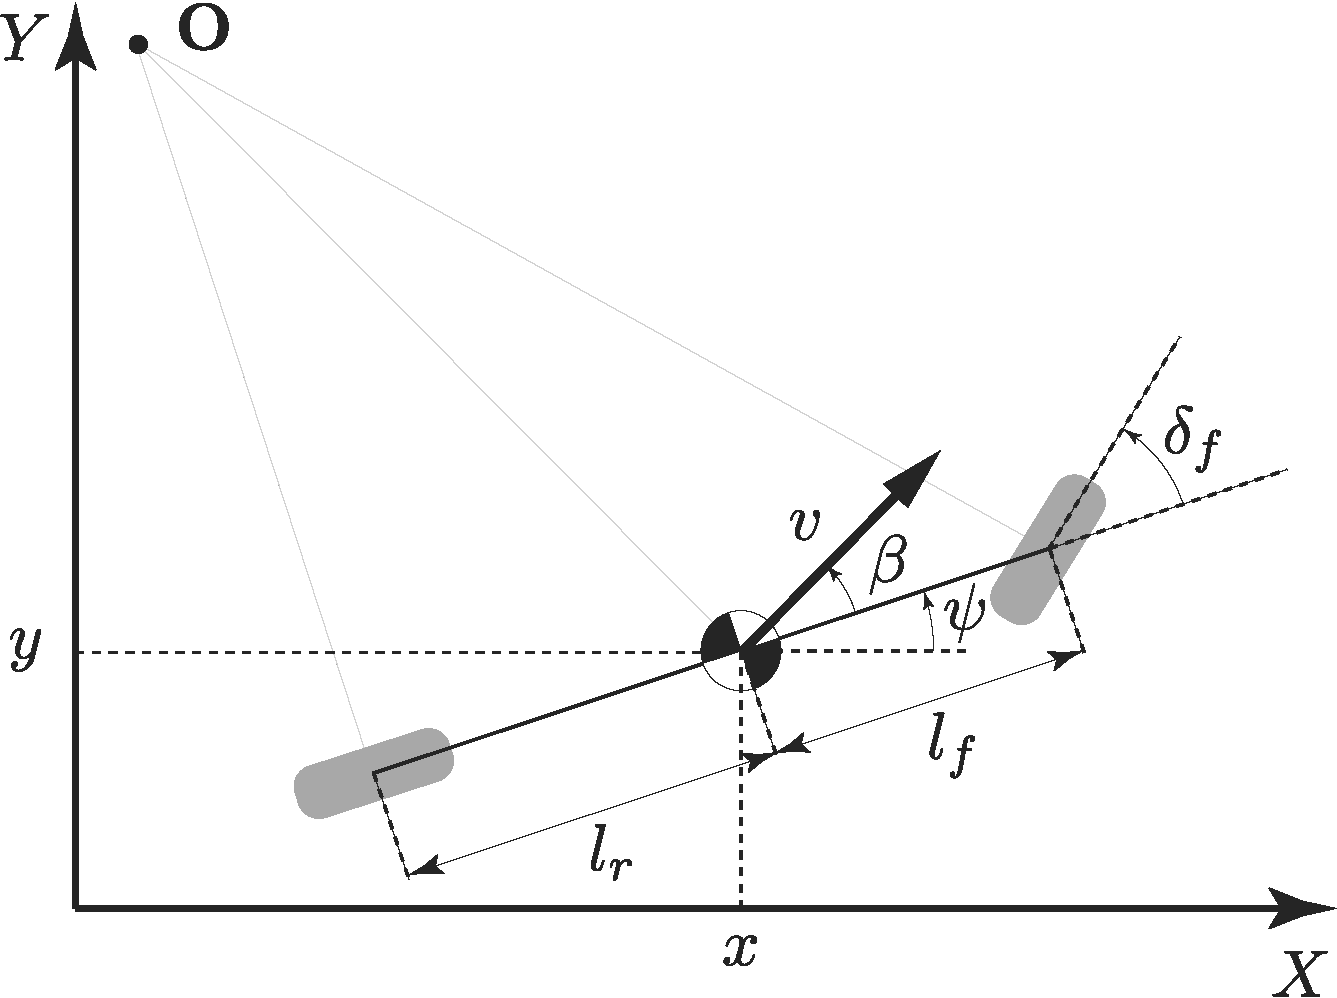 </center>

Consider a simplified kinematic bicycle model :

\begin{align}
\dot{x} &= v \cos(\psi+\beta)\\ 
\dot{y} &= v \sin(\psi+\beta)\\
\dot{\psi} &= \frac{v}{l_r} \sin(\beta)\\
\dot{v} &= a \\
\beta &= \tan^{-1} \left( \frac{l_r}{l_f+l_r}  \tan(\delta_f)\right)
\end{align}

If assume {\delta_f}, {\psi} and {\beta} are small, we can approximize the system as below : 

\begin{align}
\dot{x} &= v \\ 
\dot{y} &= v{\psi} + \frac{l_r}{l_f+l_r}v{\delta_f} \\
\dot{\psi} &= \frac{1}{l_f+l_r}v{\delta_f} \\
\dot{v} &= a \\
\end{align}

Reference : https://ieeexplore.ieee.org/document/8734145/ - Trajectory Planning for Autonomous High-Speed Overtaking in Structured Environments Using Robust MPC

In [13]:
# Car model
# Harvey, Christian, Swastika

#---------------- Parameters ---------------#
### Road Geometry #####
lane_width = 3.5 # [m]
num_lane = 2

### SV (Subject Vehicle) parameter ###
l_f = 1.446 # [m]
l_r = 1.477 # [m]
SV_v_desired = 33.33 # [m/s]


SV_initial_x = 0 # [m]
SV_initial_y = lane_width/2 # [m]
SV_initial_psi = 0
SV_initial_v = 32.67 # [m/s]

### LV (Lead Vehicle) parameter ###
# Assume they don't change their lane and run in a constant velocity
num_LV = 3
LV_l_long = 4.1
LV_w_lat = 1.7
wedge_back = 40 # modified 1
wedge_head = 55 # modified 100

# LV_information 
## For showing cacenlling lane change : SV_initial_x - 93.5, vel = 45 for the second LV
LV_initialize  = np.array([[SV_initial_x + 70, SV_initial_x + 150, SV_initial_x + 240],  # x coordinate [m] # modified. 110 220 330 
                           [SV_initial_y, SV_initial_y + lane_width, SV_initial_y],       # y coordinate [m]
                           [22.5, 22.5, 22.5]])                                           # velocity [m/s]

### Potential Field ###
A_car = 10
Xi = 3
A_lane = 36
sigma = 0.14 * lane_width
alpha = 0.16
Vertice = [[100, 0], [100, num_lane*lane_width], [-60, num_lane*lane_width], [-60, 0]]
U_safe = 10
grid_length = 0.01

### Control Parameters ###
sampling_time = 0.2
N = 10
Q = np.diag([0, 0.02, 0.01, 10])
R = np.diag([1.5, 200])
P = ...

### System Parameters ###
# SV_x has no limit
SV_y_lower = 0 # lower limit of y
SV_y_upper = num_lane*lane_width
SV_psi_lower = -0.05
SV_psi_upper = 0.05
SV_v_lower = 22.5
SV_v_upper = SV_v_desired

SV_a_upper = 1.5 # [m/s^2]
SV_a_lower = -1.5
SV_delta_upper = 0.03 # [rad]
SV_delta_lower = -0.03

X_set = pt.Polytope(np.array([[1.0, 0, 0, 0],
                              [-1.0, 0, 0, 0],
                              [0, 1.0, 0, 0],
                               [0, -1.0, 0, 0],
                               [0, 0, 1.0, 0],
                               [0, 0, -1.0, 0],
                               [0, 0, 0, 1.0],
                               [0, 0, 0, -1.0]]), 
                    np.array([[np.Inf],
                              [np.Inf],
                              [SV_y_upper],
                            [-SV_y_lower],
                            [SV_psi_upper],
                            [-SV_psi_lower],
                            [SV_v_upper],
                            [-SV_v_lower]]))

U_set = pt.Polytope(np.array([[1.0, 0],
                              [-1.0, 0],
                              [0, 1.0],
                              [0, -1.0]]), 
                    np.array([[SV_a_upper],
                              [-SV_a_lower],
                              [SV_delta_upper],
                              [-SV_delta_lower]]))

print(X_set)

### Driving mode ###
CRUISE_MODE = 0;
OVERTAKE_MODE = 1;


Single polytope 
  [[ 1.  0.  0.  0.] |    [[   inf]
   [-1.  0.  0.  0.] |     [   inf]
   [ 0.  1.  0.  0.] |     [  7.  ]
   [ 0. -1.  0.  0.] x <=  [  0.  ]
   [ 0.  0.  1.  0.] |     [  0.05]
   [ 0.  0. -1.  0.] |     [  0.05]
   [ 0.  0.  0.  1.] |     [ 33.33]
   [ 0.  0.  0. -1.]]|     [-22.5 ]]



[70.    1.75]


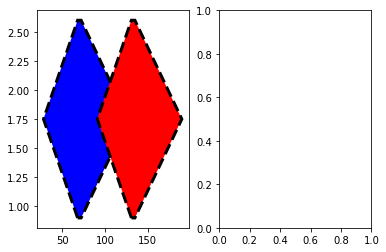

In [19]:
class Subject_vehicle :
  def __init__(self, init_x, init_y, init_psi, l_f = l_f, l_r = l_r, length = LV_l_long, width = LV_w_lat, init_vel = SV_initial_v, curr_lane = 2, head_lane = 2) :
    self.l_f = l_f
    self.l_r = l_r
    self.state = np.array([init_x, init_y, init_psi, init_vel])
    self.length = length
    self.width = width
    self.A = np.array([[1.0, 0, 0, sampling_time],
                       [0, 1.0, self.state[3]*sampling_time, 0],
                       [0, 0, 1.0, 0],
                       [0, 0, 0, 1]])
    self.B = np.array([[0, 0],
                       [0, self.state[3]*sampling_time / (self.l_f+self.l_r) * self.l_r],
                       [0, self.state[3]*sampling_time / (self.l_f+self.l_r)],
                       [sampling_time, 0]])
    self.curr_lane = curr_lane
    self.head_lane = head_lane
    self.lane_thresh = 0.05    # if SV stays 0.8m away from the head_lane, we suppose it successfully changed the lane.

  def getState(self) :
    return self.state

  def update_state_approx(self, input) :
    self.state = self.A @ self.state + self.B @ input
    self.set_curr_lane()

  def update_state_Notapprox(self, input) :
    beta = np.arctan( self.l_r / (self.l_f + self.l_r) * np.tan(input[1]))
    self.state += sampling_time * np.array([self.state[3] * np.cos(beta + self.state[2]),
                                            self.state[3] * np.sin(beta + self.state[2]),
                                            self.state[3]/self.l_r*np.sin(beta),
                                            input[0]])
    self.set_curr_lane()
  
  def get_laneInfo(self) :
    return [self.curr_lane, self.head_lane]
  
  def set_curr_lane(self) :
    head_lane_y = lane_width/2 + lane_width*(num_lane - self.head_lane)
    if abs(head_lane_y - self.state[1]) < self.lane_thresh :
      self.curr_lane = self.head_lane

  def set_head_lane(self, target_point) :
    for i in range(num_lane) :
      if target_point[1] >= i*lane_width and target_point[1] < (i+1)*lane_width :
        self.head_lane = num_lane - i
        break


class Lead_vehicle :
  def __init__(self, init_x, init_y, vel, length = LV_l_long, width = LV_w_lat, _wedge_back = wedge_back, _wedge_head = wedge_head) :
    self.pos = np.array([init_x, init_y])
    self.length = length
    self.width = width
    self.vel = vel
    self.wedge_back = _wedge_back
    self.wedge_head = _wedge_head
    self.pos_pred = np.array([self.pos[0] + N*sampling_time*self.vel, self.pos[1]])

  def getPosition(self) :
    return self.pos

  def getPosition_predict(self) :
    return self.pos_pred
  
  def updatePosition(self) :
    self.pos[0] += sampling_time * self.vel
    self.pos_pred[0] = self.pos[0] + N*sampling_time*self.vel

  def getWedgePoints(self) :
    return np.array([[self.pos[0] - self.length/2 - self.wedge_back, self.pos[1]],
                     [self.pos[0] - self.length/2, self.pos[1] + self.width/2],
                     [self.pos[0] + self.length/2, self.pos[1] + self.width/2],
                     [self.pos[0] + self.length/2 + self.wedge_head, self.pos[1]],
                     [self.pos[0] + self.length/2, self.pos[1] - self.width/2],
                     [self.pos[0] - self.length/2, self.pos[1] - self.width/2]])
    
  def getWedgePoints_predict(self) :
    current_WedgePoints = self.getWedgePoints()
    current_WedgePoints[:,0] += N*sampling_time*self.vel
    return current_WedgePoints
  
  def makePolytope(self, vertices) :
    A = np.empty((6,2))
    B = np.empty((6,1))
    idx = 0
    for i in [1,3,4,0] :
      x1, y1, x2, y2 = [vertices[i,0], vertices[i,1], vertices[i-1,0], vertices[i-1,1]]
      a = (y2-y1)/(x2-x1)
      b = y1 - a*x1
      if i in [1,3] :
        A[idx,:] = [-a, 1.0]
        B[idx,:] = [b]
      else :
        A[idx,:] = [a, -1.0]
        B[idx,:] = [-b]
      idx += 1
    A[4:,:] = [[0, 1.0], [0, -1.0]]
    B[4:,:] = [[self.width/2 + self.pos[1]], [self.width/2 - self.pos[1]]]

    return pt.Polytope(A, B)

  def getPolytope(self) :
    vertices = self.getWedgePoints()
    return self.makePolytope(vertices)

  def getPolytope_predict(self) :
    vertices = self.getWedgePoints_predict()
    return self.makePolytope(vertices)

  ###### For Animation ###############
  def getVertice_anim(self, position) :
    vertice_x = np.array([[position[0] + self.length/2, position[0] - self.length/2, position[0] - self.length/2, position[0] + self.length/2]])
    vertice_y = np.array([[position[1] + self.width/2,  position[1] + self.width/2,  position[1] - self.width/2,  position[1] - self.width/2]])
    vertice = np.concatenate((vertice_x.T, vertice_y.T), axis=1)
    return vertice

  def getWedgePoints_anim(self, position) :
    WedgePoints = np.array([[position[0] - self.length/2 - self.wedge_back, position[1]],
                            [position[0] - self.length/2, position[1] + self.width/2],
                            [position[0] + self.length/2, position[1] + self.width/2],
                            [position[0] + self.length/2 + self.wedge_head, position[1]],
                            [position[0] + self.length/2, position[1] - self.width/2],
                            [position[0] - self.length/2, position[1] - self.width/2]])
    return WedgePoints

SV = Subject_vehicle(init_x = SV_initial_x, init_y = SV_initial_y, init_psi = SV_initial_psi)
LV1 = Lead_vehicle(LV_initialize[0,0], LV_initialize[1,0], LV_initialize[2,0])
LV2 = Lead_vehicle(LV_initialize[0,1], LV_initialize[1,1], LV_initialize[2,1])
print(LV1.getPosition())
fig, ax = plt.subplots(1,2)
X = LV1.getPolytope()
X_pred = LV1.getPolytope_predict()
X.plot(ax[0], color='b')
X_pred.plot(ax[0], color='r')
ax[0].autoscale_view()
#ax[0].set_zlim([-10,10])
#ax[0].axis('equal')


In [8]:
# Detect LVs
# Should detect LVs within 100m from SV
# Should know which LV is in front of SV or on the lane to which SV plans to move
def detect_LV(SV, LV_list) :
  x, v = SV.getState()[[0,3]]
  x_pred = x + v * sampling_time * N
  idx_front = -1
  idx_side = -1
  min_x_i = np.inf
  max_x_i_pred = -1

  
  for i in range(len(LV_list)) :
    lane_i = 0

    # get lane information of each LV
    [x_i, y_i] = LV_list[i].getPosition()
    for j in range(num_lane) :
      if y_i >= j*lane_width and y_i < (j+1)*lane_width :
        lane_i = num_lane - j
        break

    # Find out LV in front of SV
    if lane_i == SV.curr_lane :
      if x_i > x and x_i < min_x_i :
        min_x_i = x_i
        idx_front = i

    # Find out LV on the lane to which SV plans to move (All LVs whose predicted position is behind predicted position of SV)
    # In this case, since there are only 2 lanes, just 'else' is enough
    else :
      x_i_pred = LV_list[i].getPosition_predict()[0]
      if x_pred > x_i_pred and x_i_pred > max_x_i_pred :
        max_x_i_pred = x_i_pred
        idx_side = i      
    
  return [idx_front, idx_side]
#-------------------------------------------------------------------------------#

# Reachability set - without accelerating
# with original system and ts=0.1, 20 step : 3m 17s
# with simple system and ts=0.2, 10 step : 1s (erasing acceleration term from the input vector)
# with simple system and ts=0.1, 20 step : 5s

def get_reachable_set(x0, y0, psi0, v0, ts, N) :
  eps_pos = 0.01
  eps = 0.0001
  A_sys = np.array([[1.0, 0, 0, ts],
                    [0, 1.0, v0*ts, 0],
                    [0, 0, 1.0, 0],
                    [0, 0, 0, 1.0]])
  '''
  B_sys = np.array([[0, 0],
                    [0, v0*l_r*ts/(l_f+l_r)],
                    [0, v0*ts/(l_f+l_r)],
                    [ts, 0]])
  '''
  B_sys = np.array([[0],
                    [v0*l_r*ts/(l_f+l_r)],
                    [v0*ts/(l_f+l_r)],
                    [0]])
  X = pt.Polytope(np.array([[1.0, 0, 0, 0], 
                            [-1.0, 0, 0, 0],
                            [0, 1.0, 0, 0],
                            [0, -1.0, 0, 0],
                            [0, 0, 1.0, 0],
                            [0, 0, -1.0, 0],
                            [0, 0, 0, 1.0],
                            [0, 0, 0, -1.0]]), 
                  np.array([[x0], 
                            [-x0+2*eps_pos],
                            [y0+eps],
                            [-y0+eps],
                            [psi0+eps],
                            [-psi0+eps],
                            [v0+eps],
                            [-v0+eps]]))
  '''
  U = pt.Polytope(np.array([[1.0, 0], 
                            [-1.0, 0],
                            [0, 1.0],
                            [0, -1.0]]),
                  np.array([[0.0], 
                            [-SV_a_lower],
                            [SV_delta_upper],
                            [-SV_delta_lower]]))
  '''
  U = pt.Polytope(np.array([[1.0],
                            [-1.0]]),
                  np.array([[SV_delta_upper],
                            [-SV_delta_lower]]))
  
  for i in range(N) :
    X = successor(X, A_sys, U, B_sys).intersect(X_set)
  # print("Calculation of reachable set is done")
  return X

def get_point_in_2D_bbox(reachable_set, test = False) :
  pt_tmp = reachable_set.project([1,2])  # project the reachable set to x-y plane
  pt_tmp = pt_tmp.bounding_box           # pt_tmp = two corner of the bounding box of the projection : left_lower, right_upper
  x = np.arange(pt_tmp[0][0,0], pt_tmp[1][0,0], grid_length)
  
  threshold = 0.001
  if pt_tmp[0][1,0] < threshold :
    pt_tmp[0][1,0] += grid_length
  if pt_tmp[1][1,0] > num_lane*lane_width - threshold :
    pt_tmp[1][1,0] -= grid_length
    
  y = np.arange(pt_tmp[0][1,0], pt_tmp[1][1,0], grid_length)

  # Only for test - return points on large area
  if test :
    x = np.linspace(40, 70, 100)
    y = np.linspace(grid_length, num_lane*lane_width-grid_length, 100)
  ########
  
  xx, yy = np.meshgrid(x, y)
  return xx, yy

##### Potential Funtions - road potential, lane potential, car potential #####

# road potential - a potential function that prevents SV from getting closer to edges of the road
def road_potential(target) :
  road_risk = 0.5*Xi*((1/(target[1]-num_lane*lane_width))**2 + (1/target[1])**2)
  return road_risk

# lane potential - a potential function that forces SV to stay in the middle of the road
def lane_potential(target) :
  lane_risk = 0
  for i in range(num_lane+1) : 
    lane_risk += A_lane * np.exp( -(target[1]-i*lane_width)**2 / (2*(sigma**2)) )
  return lane_risk

# car_potential - a potential function that make SV stay away from LVs.
def car_potential(target, LV, turn_off) :
  if target in LV.getPolytope_predict() :  # modified LV.getPolytope()
    return np.Inf

  if turn_off :
    return 0
  point = LV.getWedgePoints_predict()     # modified LV.getWedgePoints()
  length = np.linalg.norm(target - point[0])
  for i in range(point.shape[0]-1) :
    tmp = np.linalg.norm(target - point[i+1])
    if length > tmp :
      length = tmp

  car_risk = A_car * (np.exp(-alpha*length)) / length 
  return car_risk

# Get risk value based on potential functions. If the return value is lower than U_safe, it's safe
def risk_value(target, _LV1, _LV2=None, _LV3=None, car_potential_off = True) :
  if _LV2 == None :
    return road_potential(target) + lane_potential(target) + car_potential(target, _LV1, car_potential_off)
  if _LV3 == None :
    return road_potential(target) + lane_potential(target) + car_potential(target, _LV1, car_potential_off) + car_potential(target, _LV2, car_potential_off)
  return road_potential(target) + lane_potential(target) + car_potential(target, _LV1, car_potential_off) + car_potential(target, _LV2, car_potential_off) + car_potential(target, _LV3, car_potential_off)
#----------------------------------------------------------------------------#

# Among the points in reachable set, choose a target point using the risk map
def get_target_state(risk_map, initial_x, print_safe_map = False, Subject_vehicle = SV, mode = OVERTAKE_MODE) :
  safe_map = risk_map[:, risk_map[2,:] < U_safe]             # filter the points in risk map that pass safe standard
  
  # If there's no safe point. Obtain safe_map with increased threshold
  '''
  U_tmp = U_safe
  while np.size(safe_map,1) == 0 :
    print('Safe threshold increased')
    U_tmp += 1
    safe_map = risk_map[:, risk_map[2,:] < U_tmp]
  '''
  
  target_x = np.amax(safe_map[0,:])                           # obtain the farthest distance in terms of x-dir
  safe_map = safe_map[:, safe_map[0,:] == target_x]           # choose the farthest safe points
  if(print_safe_map) :
    print(safe_map)
  lowest_risk_point = safe_map[:, np.argmin(safe_map[2,:])]   # choose the safest point among the farthest safe points 
  target_vel = (lowest_risk_point[0] - initial_x) / (sampling_time*N)
  target_psi = 0
  target_state = np.array([lowest_risk_point[0], lowest_risk_point[1], target_psi, target_vel, lowest_risk_point[2]])
  # print(target_state)
  SV.set_head_lane(target_state[:2])
  
  return target_state

  #---------------------------------------------------------------------------#


In [32]:
#### test ####
'''
test = get_reachable_set(SV_initial_x, SV_initial_y, 0.03, SV_initial_v, 0.2, 10)
get_point_in_2D_bbox(test)
X = test.project([1,2])
print(X)

fig, ax = plt.subplots(1,2)
X.plot(ax[0], color='b')
ax[0].legend(['X', 'X & Pre(X, W)'])
ax[0].autoscale_view()
ax[0].axis('equal')


X = X.bounding_box
print(X)
print(X[0][1,0])
for a,b in X :
  print("corner : x : " + str(a[0]) + " y : " + str(b[0]))
  '''
##########
# 6.666  ]
#  [ 1.75     1.79245]
#  [ 0.       0.02874]
#  [33.33    33.48603
SV = Subject_vehicle(init_x = SV_initial_x, init_y = SV_initial_y, init_psi = SV_initial_psi)
LV1 = Lead_vehicle(LV_initialize[0,0], LV_initialize[1,0], LV_initialize[2,0])
LV2 = Lead_vehicle(LV_initialize[0,1], LV_initialize[1,1], LV_initialize[2,1])

U_safe = np.Inf
xx, yy = get_point_in_2D_bbox(get_reachable_set(SV.getState()[0], SV.getState()[1], SV.getState()[2], SV.getState()[3], 0.2, 10), False)
risk_map = np.zeros((3,xx.size))
index = 0
for i in range(xx.shape[0]) :
  for j in range(xx.shape[1]) :
    risk_map[0,index] = xx[i,j]
    risk_map[1,index] = yy[i,j]
    risk_map[2,index] = risk_value(np.array([xx[i,j], yy[i,j]]), LV1)
    index += 1

test_target_point = get_target_state(risk_map, SV.getState()[0])
risk_map = risk_map[:, risk_map[2,:]<U_safe]

ax = plt.axes(projection='3d')
ax.scatter3D(risk_map[0,:], risk_map[1,:], risk_map[2,:], alpha = 0.1, c = risk_map[0,:] + risk_map[1,:] +risk_map[2,:], cmap = plt.get_cmap('hsv'))
ax.scatter3D(test_target_point[0], test_target_point[1], test_target_point[4])
ax.set_zlim(0, 150);
print('SV state : ')
print(SV.getState())
print('LV position - LV1 : ')
print(LV1.getPosition())
print('LV2 : ')
print(LV2.getPosition())
print(test_target_point)


ValueError: ignored

In [22]:
# Solve CFTOC for car
from __future__ import division

def solve_cftoc_onlyCar(A, B, P, Q, R, N, x0, X_set, U_set, bf, Af, SV, LV_info, LV_list, reachable_set, add_extra_constraint) :
  model = pyo.ConcreteModel()
  model.A = A
  model.B = B
  model.P = P
  model.Q = Q
  model.R = R
  model.N = N
  model.Af = Af
  model.SV = SV
  model.LV_front = LV_list[LV_info[0]]  if LV_info[0] != -1 else None
  model.LV_side = LV_list[LV_info[1]]   if LV_info[1] != -1 else None
  model.X_set = X_set
  model.U_set = U_set
  
  model.nx = np.size(A,1)
  model.nu = np.size(B,1)

  model.tidx = pyo.Set(initialize = range(0,N+1))
  model.xidx = pyo.Set(initialize = range(0, model.nx))
  model.uidx = pyo.Set(initialize = range(0, model.nu))

  model.x = pyo.Var(model.xidx, model.tidx)
  model.u = pyo.Var(model.uidx, model.tidx)
  model.target_state = bf
  model.strict_terminalConst = True

  eps = 0.001

  def Objective_func_rule(model) :
    costP = 0
    costQ = 0
    costR = 0

    for t in model.tidx :
      for i in model.xidx :
        if t < model.N :
          costQ += (model.x[i,t] - model.target_state[i]) * model.Q[i,i] * (model.x[i,t] - model.target_state[i])

    for t in model.tidx :
      for i in model.uidx :
        if t < model.N :
          costR += model.u[i,t] * model.R[i,i] * model.u[i,t]

    for i in model.xidx :
      for j in model.xidx :
        costP += (model.x[i,model.N] - model.target_state[i]) * model.P[i,j] * (model.x[j,model.N] - model.target_state[i])

    return costP + costQ + costR

  model.cost = pyo.Objective(rule = Objective_func_rule, sense = pyo.minimize)

  def Equality_constraint_rule(model, i, t) :
    return (sum(model.A[i,j] * model.x[j,t] for j in model.xidx) + sum(model.B[i,j] * model.u[j,t] for j in model.uidx)) - model.x[i,t+1] == 0 if t<model.N else pyo.Constraint.Skip

  def Initial_constraint_rule(model, i) :
    return model.x[i,0] - x0[i] == 0

  # When Af == [] & bf != [], x_terminal_value == x_target and y_terminal_value == y_target. This constraint may be modified 
  def Terminal_constraint_rule(model, i) :
    if model.Af == [] :
      if model.target_state == [] :
        return pyo.Constraint.Skip
      else :
        model.strict_terminalConst = True
        return model.x[i,N] - model.target_state[i] == 0 if i<2 else pyo.Constraint.Skip   # This may be modified
    else :
      # When the terminal constraint is like target_x-eps <= x <= target_x+eps, target_y-eps <= y <= target_y+eps, ...
      model.strict_terminalConst = False
      if np.size(model.Af, 1) == 2 :
        # [x_eps, y_eps, psi_eps, v_eps] = [0.1, 0.1, 0.01, 0.01]
        # model.target_state = np.array([bf[0] + x_eps, -bf[0] + x_eps, bf[1] + y_eps, -bf[1] + y_eps, 
        #                                bf[2] + psi_eps, -bf[2] + psi_eps, bf[3] + v_eps, -bf[3] + v_eps])
        [x_eps, y_eps] = [0.5, 0.5]
        model.target_state = np.array([bf[0] + x_eps, -bf[0] + x_eps, bf[1] + y_eps, -bf[1] + y_eps])
        return sum(model.Af[i,j] * model.x[j,N] for j in range(0,2)) - model.target_state[i] <= 0
      else :
        return sum(model.Af[i,j] * model.x[j,N] for j in range(0,2)) - model.target_state[i] <= 0

  def Inequality_constraint_rule_state(model, i, t) :
    return sum(model.X_set.A[i,j] * model.x[j,t] for j in model.xidx) - model.X_set.b[i] <= 0

  def Inequality_constraint_rule_input(model, i, t) :
    return sum(model.U_set.A[i,j] * model.u[j,t] for j in model.uidx) - model.U_set.b[i] <= 0

  model.equalityConst = pyo.Constraint(model.xidx, model.tidx, rule = Equality_constraint_rule)
  model.initConst = pyo.Constraint(model.xidx, rule = Initial_constraint_rule) 
  
  if model.strict_terminalConst :
    model.terminalConst = pyo.Constraint(model.xidx, rule = Terminal_constraint_rule)
  else :
    model.terminalConst = pyo.Constraint(range(0,4), rule = Terminal_constraint_rule)
 
  # model.StateConst = pyo.Constraint(model.xidx, model.tidx, rule = Inequality_constraint_rule_state)
  model.InputConst = pyo.Constraint(model.uidx, model.tidx, rule = Inequality_constraint_rule_input)
  model.StateConst1 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[1,t] <= SV_y_upper )
  model.StateConst2 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[2,t] <= SV_psi_upper if t>0 else pyo.Constraint.Skip)
  model.StateConst3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[3,t] <= SV_v_upper)
  model.StateConst4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[1,t] >= SV_y_lower)
  model.StateConst5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[2,t] >= SV_psi_lower if t>0 else pyo.Constraint.Skip)
  model.StateConst6 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[3,t] >= SV_v_lower)
  

  # For debug
  [front_x1, front_y1, front_x2, front_y2, side_x1, side_y1, side_x2, side_y2] = [0,0,1,0,0,0,1,0]
  # When the heading line and the current line are different 
  if model.SV.get_laneInfo()[0] != model.SV.get_laneInfo()[1] and add_extra_constraint :
    print('Move from lane', model.SV.get_laneInfo()[0], 'to', model.SV.get_laneInfo()[1], '. LV info : ', LV_info[0], ' ', LV_info[1])
    # When SV heads to the second lane from the first lane
    if model.SV.get_laneInfo()[0] == 1 :
      if(model.LV_front != None) :
        [front_x1, front_y1] = model.LV_front.getWedgePoints()[0,:]
        [front_x2, front_y2] = model.LV_front.getWedgePoints()[5,:]
        
        def Inequality_extraConstraint_rule_state_front(model, t) :
          return model.x[1,t] - front_y1 - ((front_y2-front_y1)/(front_x2-front_x1))*(model.x[0,t] - front_x1) <= 0
        model.StateConst7 = pyo.Constraint(model.tidx, rule=Inequality_extraConstraint_rule_state_front)
     
      if(model.LV_side != None) :
        [side_x1, side_y1]   = model.LV_side.getWedgePoints()[2,:]
        [side_x2, side_y2]   = model.LV_side.getWedgePoints()[3,:]

        def Inequality_extraConstraint_rule_state_side(model, t) :
          return -model.x[1,t] + side_y1 + ((side_y2 -side_y1 )/(side_x2 -side_x1 ))*(model.x[0,t] - side_x1 ) <= 0
        model.StateConst8 = pyo.Constraint(model.tidx, rule=Inequality_extraConstraint_rule_state_side)
    
    # When SV heads to the first lane from the second lane
    else :
      if(model.LV_front != None) :
        [front_x1, front_y1] = model.LV_front.getWedgePoints()[0,:]
        [front_x2, front_y2] = model.LV_front.getWedgePoints()[1,:]

        def Inequality_extraConstraint_rule_state_front(model, t) :
          return -model.x[1,t] + front_y1 + ((front_y2-front_y1)/(front_x2-front_x1))*(model.x[0,t] - front_x1) <= 0
        model.StateConst7 = pyo.Constraint(model.tidx, rule=Inequality_extraConstraint_rule_state_front)

      if(model.LV_side != None) :
        print('bug check')
        [side_x1, side_y1]   = model.LV_side.getWedgePoints()[3,:]
        [side_x2, side_y2]   = model.LV_side.getWedgePoints()[4,:]

        def Inequality_extraConstraint_rule_state_side(model, t) :
          return model.x[1,t] - side_y1 - ((side_y2 -side_y1 )/(side_x2 -side_x1 ))*(model.x[0,t] - side_x1 ) <= 0
        model.StateConst8 = pyo.Constraint(model.tidx, rule=Inequality_extraConstraint_rule_state_side)
    

  # print(model.StateConst)
  # if model.SV.get_laneInfo()[0] == 2 and model.SV.get_laneInfo()[1] == 1 :
  #   model.display()
  solver = pyo.SolverFactory('ipopt')
  results = solver.solve(model)
  # results_write = results.write()

  if results.solver.termination_condition == pyo.TerminationCondition.optimal :
    feas = True
  else :
    feas = False
    model.display()
  
  xOpt = np.asarray([[pyo.value(model.x[i,t]) for t in model.tidx] for i in model.xidx])
  uOpt = np.asarray([[pyo.value(model.u[i,t]) for t in model.tidx if t<model.N] for i in model.uidx])
  JOpt = model.cost()

  wedge_LV1 = LV_list[0].getWedgePoints()
  wedge_LV1_predicted = LV_list[0].getWedgePoints_predict();
  wedge_LV2 = LV_list[1].getWedgePoints()
  wedge_LV2_predicted = LV_list[1].getWedgePoints_predict();

  fig, ax = plt.subplots(1,1,figsize=(9,6))
  # actual = plt.plot(xOpt[0,:], xOpt[1,:], 'ko-')
  ax.plot(xOpt[0,:], xOpt[1,:], 'y*--', linewidth=1)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_title('State Trajectory')
  ax.fill(wedge_LV1[:,0], wedge_LV1[:,1], alpha = 0.2, c = 'g')
  ax.fill(wedge_LV2[:,0], wedge_LV2[:,1], alpha = 0.2, c = 'g')
  ax.fill(wedge_LV1_predicted[:,0], wedge_LV1_predicted[:,1], alpha = 0.2, c = 'r')
  ax.fill(wedge_LV2_predicted[:,0], wedge_LV2_predicted[:,1], alpha = 0.2, c = 'r')

  reachable_set.plot(ax)
  plt.show()
  tmp_float = np.zeros((2, N+1))
  tmp_bool = np.zeros((2, N+1), dtype=bool)
  
  print('SV Lane Info : ', SV.get_laneInfo())
  print('LV info : ', LV_info)
  if model.SV.get_laneInfo()[0] != model.SV.get_laneInfo()[1] :
    for i in model.tidx :
      tmp_front = -xOpt[1,i] + front_y1 + ((front_y2-front_y1)/(front_x2-front_x1))*(xOpt[0,i] - front_x1)
      tmp_side = xOpt[1,i] - side_y1 - ((side_y2 -side_y1 )/(side_x2 -side_x1 ))*(xOpt[0,i] - side_x1 )
      tmp_float[0,i] = tmp_front
      tmp_float[1,i] = tmp_side
      tmp_bool[0,i] = tmp_front <= 0
      tmp_bool[1,i] = tmp_side <= 0

    print(tmp_float)
    print(tmp_bool)

  return [feas, xOpt, uOpt, JOpt]

## Example problem from Lab8
# A = np.array([[1, 1],
#                [0, 1]])
# B = np.array([[0],
#               [1]])
# Q = np.eye(2)
# R = 10*np.array([1]).reshape(1,1)
# P = Q
# N = 3
# xL = -5
# xU = 5
# uL = -0.5
# uU = 0.5
# x0 = np.array([-4.5, 2])
# bf = []
# Af = []

# [feas, xOpt, uOpt, JOpt] = solve_cftoc(A, B, P, Q, R, N, x0, xL, xU, uL, uU, bf, Af)


risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


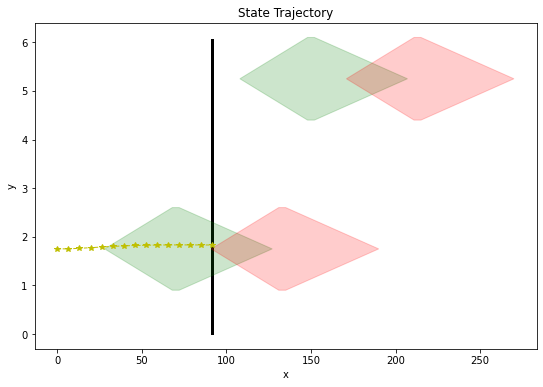

SV Lane Info :  [2, 2]
LV info :  [0, -1]
0 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


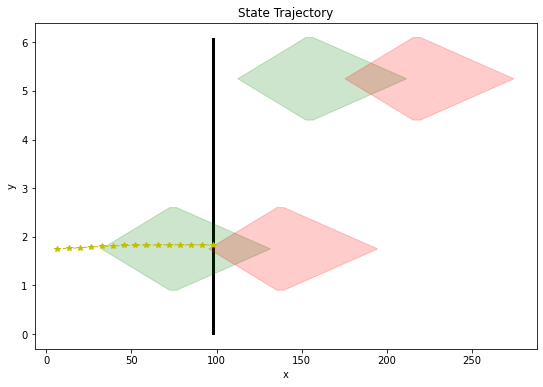

SV Lane Info :  [2, 2]
LV info :  [0, -1]
1 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 2 to 1 . LV info :  0   -1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


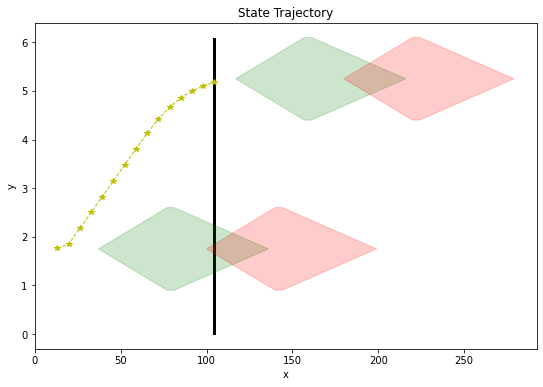

SV Lane Info :  [2, 1]
LV info :  [0, -1]
[[-0.5194  -0.46457 -0.65243 -0.84028 -1.02813 -1.21599 -1.40384 -1.59169
  -1.77454 -1.92949 -2.03517 -2.08632 -2.08862 -2.05462 -2.00067]
 [ 1.76191  1.84593  2.17263  2.49933  2.82603  3.15273  3.47943  3.80613
   4.12782  4.42162  4.66615  4.85614  4.99729  5.10213  5.18704]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]
 [False False False False False False False False False False False False
  False False False]]
2 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 2 to 1 . LV info :  0   -1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


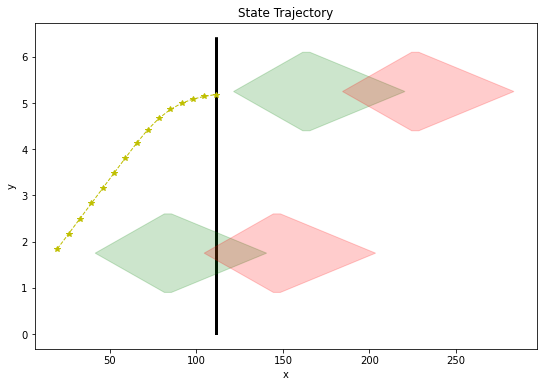

SV Lane Info :  [2, 1]
LV info :  [0, -1]
[[-0.56022 -0.74809 -0.93594 -1.1238  -1.31165 -1.4995  -1.68736 -1.87089
  -2.02897 -2.13748 -2.18836 -2.18438 -2.13501 -2.05361 -1.9554 ]
 [ 1.84593  2.17266  2.49936  2.82606  3.15276  3.47946  3.80616  4.12853
   4.42546  4.67282  4.86255  4.99741  5.08689  5.14434  5.18497]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]
 [False False False False False False False False False False False False
  False False False]]
3 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 2 to 1 . LV info :  0   -1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


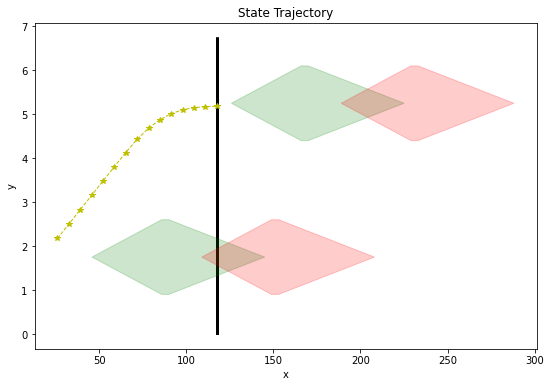

SV Lane Info :  [2, 1]
LV info :  [0, -1]
[[-0.84375 -1.03161 -1.21946 -1.40731 -1.59517 -1.78302 -1.96728 -2.12894
  -2.24236 -2.29783 -2.29628 -2.2451  -2.15517 -2.039   -1.9096 ]
 [ 2.17252  2.49922  2.82592  3.15262  3.47932  3.80602  4.12912  4.42963
   4.6819   4.87622  5.01351  5.10117  5.15009  5.17277  5.18222]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]
 [False False False False False False False False False False False False
  False False False]]
4 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 2 to 1 . LV info :  0   -1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


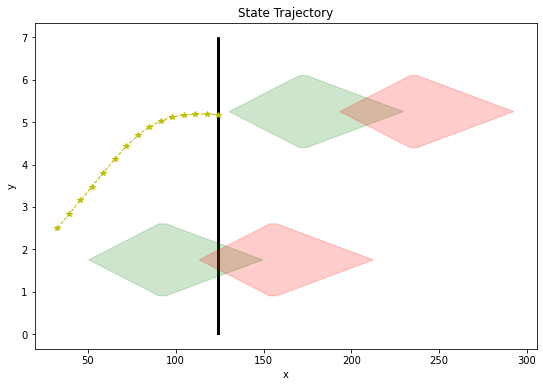

SV Lane Info :  [2, 1]
LV info :  [0, -1]
[[-1.12727 -1.31512 -1.50297 -1.69083 -1.87868 -2.06344 -2.22771 -2.34519
  -2.40551 -2.40875 -2.36118 -2.27227 -2.15263 -2.01297 -1.86363]
 [ 2.49908  2.82578  3.15248  3.47918  3.80588  4.12949  4.4326   4.68893
   4.8881   5.03018  5.12146  5.17139  5.1906   5.18979  5.17929]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]
 [False False False False False False False False False False False False
  False False False]]
5 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 2 to 1 . LV info :  0   -1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


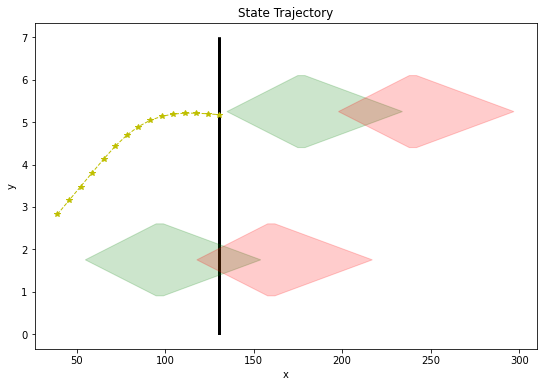

SV Lane Info :  [2, 1]
LV info :  [0, -1]
[[-1.41078 -1.59863 -1.78649 -1.97434 -2.15936 -2.32503 -2.44496 -2.50863
  -2.51592 -2.47273 -2.38789 -2.27107 -2.13161 -1.97799 -1.81784]
 [ 2.82564  3.15234  3.47904  3.80574  4.12961  4.43412  4.6929   4.89542
   5.04156  5.13721  5.19122  5.21324  5.21263  5.19785  5.17655]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]
 [False False False False False False False False False False False False
  False False False]]
6 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 2 to 1 . LV info :  0   -1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


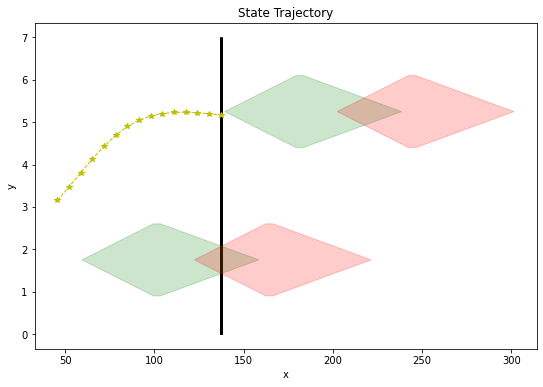

SV Lane Info :  [2, 1]
LV info :  [0, -1]
[[-1.69429 -1.88215 -2.07    -2.25512 -2.4213  -2.54229 -2.6077  -2.61744
  -2.57743 -2.49638 -2.38364 -2.24796 -2.09688 -1.93664 -1.77246]
 [ 3.1522   3.4789   3.8056   4.12956  4.43459  4.69443  4.89868  5.04727
   5.14611  5.2039   5.23001  5.23317  5.22094  5.19955  5.17421]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]
 [False False False False False False False False False False False False
  False False False]]
7 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 2 to 1 . LV info :  0   -1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


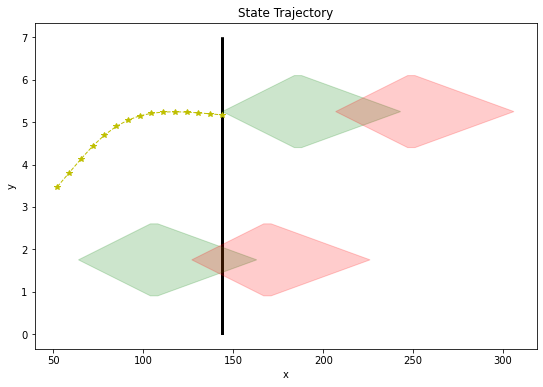

SV Lane Info :  [2, 1]
LV info :  [0, -1]
[[-1.97781 -2.16566 -2.35078 -2.51701 -2.63825 -2.70424 -2.71506 -2.67676
  -2.59813 -2.48853 -2.35658 -2.20953 -2.05302 -1.8913  -1.72758]
 [ 3.47877  3.80547  4.12943  4.4345   4.69459  4.89943  5.0491   5.14964
   5.20985  5.2391   5.246    5.23779  5.22013  5.19726  5.17238]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]
 [False False False False False False False False False False False False
  False False False]]
8 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 2 to 1 . LV info :  0   -1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


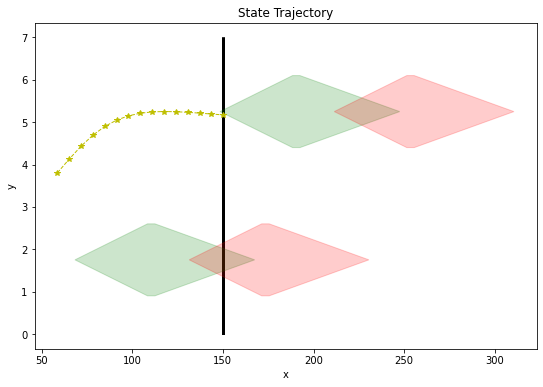

SV Lane Info :  [2, 1]
LV info :  [0, -1]
[[-2.26132 -2.44641 -2.61252 -2.73364 -2.79965 -2.81073 -2.77306 -2.69556
  -2.58772 -2.45823 -2.31434 -2.16159 -2.00389 -1.84387 -1.6832 ]
 [ 3.80533  4.12926  4.43421  4.69419  4.89904  5.04897  5.15014  5.21149
   5.24249  5.25185  5.2468   5.23289  5.21405  5.19287  5.17104]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]
 [False False False False False False False False False False False False
  False False False]]
9 th step ended
---------------------------------------------------------------------
risk value :  0.6458162957595186
Move from lane 2 to 1 . LV info :  0   -1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


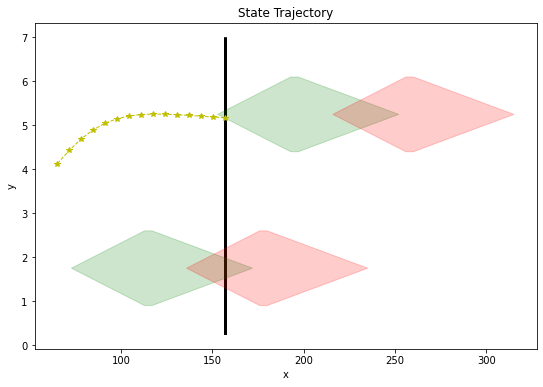

SV Lane Info :  [2, 1]
LV info :  [0, -1]
[[-2.54207 -2.70823 -2.82963 -2.89602 -2.90757 -2.87046 -2.79369 -2.68684
  -2.55876 -2.4168  -2.2666  -2.1121  -1.95582 -1.79912 -1.64261]
 [ 4.12913  4.43413  4.69438  4.89962  5.05001  5.15174  5.21382  5.24582
   5.25658  5.25347  5.24211  5.22646  5.20902  5.19116  5.17351]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]
 [False False False False False False False False False False False False
  False False False]]
10 th step ended
---------------------------------------------------------------------
risk value :  0.6458159751621387
Move from lane 2 to 1 . LV info :  0   -1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


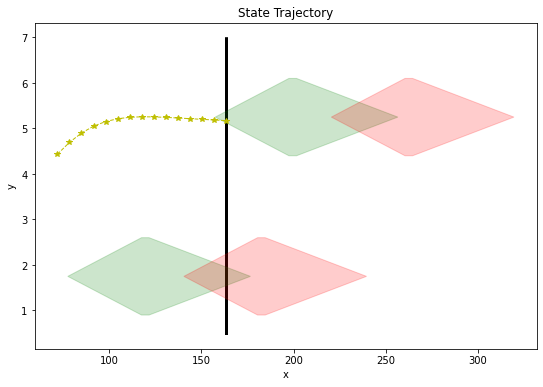

SV Lane Info :  [2, 1]
LV info :  [0, -1]
[[-2.80389 -2.92528 -2.99162 -3.00308 -2.9659  -2.88913 -2.78243 -2.65473
  -2.51351 -2.36453 -2.21185 -2.05805 -1.90452 -1.75175 -1.59965]
 [ 4.43402  4.69425  4.89944  5.04975  5.15141  5.21348  5.24563  5.25678
   5.2544   5.24426  5.23043  5.21548  5.20079  5.18686  5.17361]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]
 [False False False False False False False False False False False False
  False False False]]
11 th step ended
---------------------------------------------------------------------
risk value :  0.6458560058153099
Move from lane 2 to 1 . LV info :  0   -1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


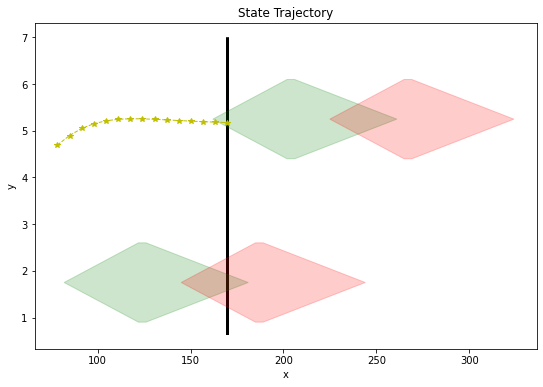

SV Lane Info :  [2, 1]
LV info :  [0, -1]
[[-3.02095 -3.08734 -3.09906 -3.06221 -2.98577 -2.87937 -2.75199 -2.61116
  -2.46273 -2.3109  -2.15838 -2.00668 -1.85638 -1.70742 -1.55934]
 [ 4.69418  4.89942  5.04999  5.15198  5.21438  5.24684  5.2583   5.25631
   5.24673  5.23375  5.22007  5.20721  5.19575  5.18564  5.1764 ]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]
 [False False False False False False False False False False False False
  False False False]]
12 th step ended
---------------------------------------------------------------------
risk value :  0.6458170451806879
Move from lane 2 to 1 . LV info :  0   -1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


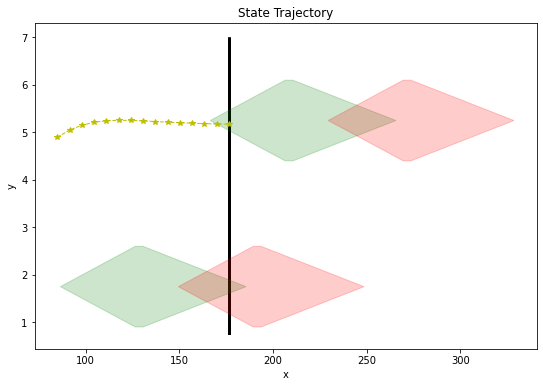

SV Lane Info :  [2, 1]
LV info :  [0, -1]
[[-3.18299 -3.1946  -3.15717 -3.07992 -2.97266 -2.84446 -2.70296 -2.55408
  -2.40207 -2.24973 -2.09866 -1.94953 -1.80239 -1.65683 -1.51218]
 [ 4.89938  5.04983  5.15125  5.21284  5.24442  5.25508  5.25242  5.24238
   5.22922  5.21572  5.20349  5.19322  5.18492  5.1782   5.17239]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]
 [False False False False False False False False False False False False
  False False False]]
13 th step ended
---------------------------------------------------------------------
risk value :  0.6458164856243176
Move from lane 2 to 1 . LV info :  0   -1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


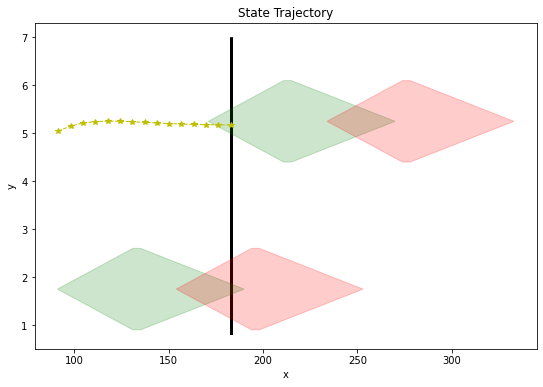

SV Lane Info :  [2, 1]
LV info :  [0, -1]
[[-3.29025 -3.25283 -3.17563 -3.06842 -2.94025 -2.79872 -2.64979 -2.49773
  -2.34541 -2.19448 -2.04574 -1.89933 -1.75497 -1.61211 -1.47008]
 [ 5.04982  5.15125  5.21289  5.24453  5.2552   5.25252  5.24243  5.22922
   5.21574  5.20366  5.19376  5.18619  5.18068  5.17667  5.17348]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]
 [False False False False False False False False False False False False
  False False False]]
14 th step ended
---------------------------------------------------------------------
risk value :  0.6458172360295459
Move from lane 2 to 1 . LV info :  0   -1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


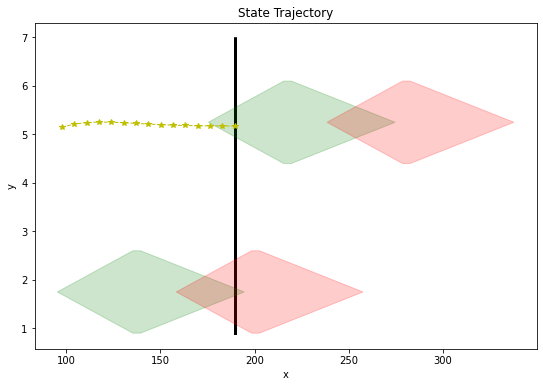

SV Lane Info :  [2, 1]
LV info :  [0, -1]
[[-3.34847 -3.27123 -3.16384 -3.03539 -2.89355 -2.74428 -2.5919  -2.43929
  -2.28815 -2.1393  -1.99297 -1.84896 -1.70684 -1.56602 -1.42588]
 [ 5.15124  5.21285  5.2443   5.2547   5.2517   5.24128  5.22775  5.21398
   5.20168  5.19168  5.18419  5.17903  5.17575  5.17378  5.17248]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]
 [False False False False False False False False False False False False
  False False False]]
15 th step ended
---------------------------------------------------------------------
risk value :  0.6458751817966093


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


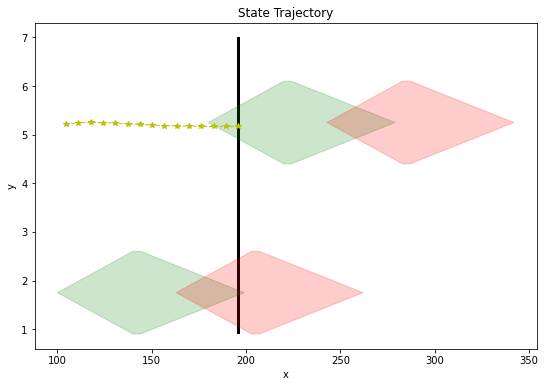

SV Lane Info :  [1, 1]
LV info :  [1, -1]
16 th step ended
---------------------------------------------------------------------
risk value :  0.6458173486086528


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


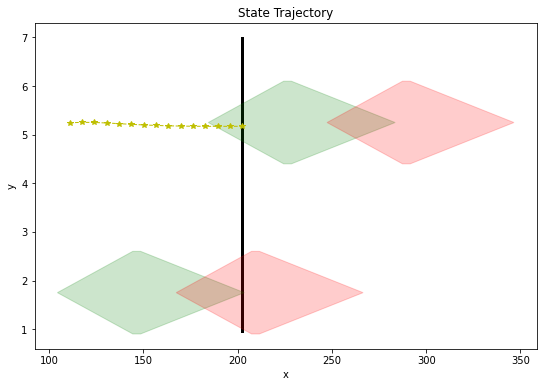

SV Lane Info :  [1, 1]
LV info :  [1, -1]
17 th step ended
---------------------------------------------------------------------
risk value :  0.6458302150729103


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


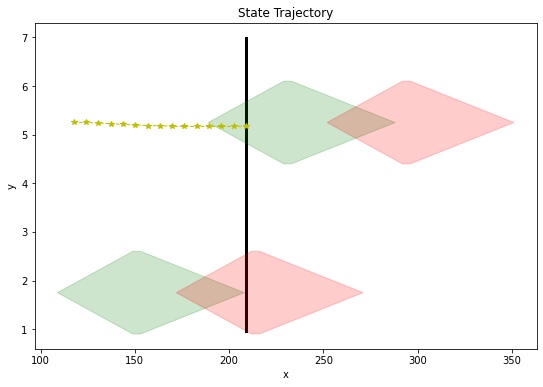

SV Lane Info :  [1, 1]
LV info :  [1, -1]
18 th step ended
---------------------------------------------------------------------
risk value :  0.6458283136622753


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


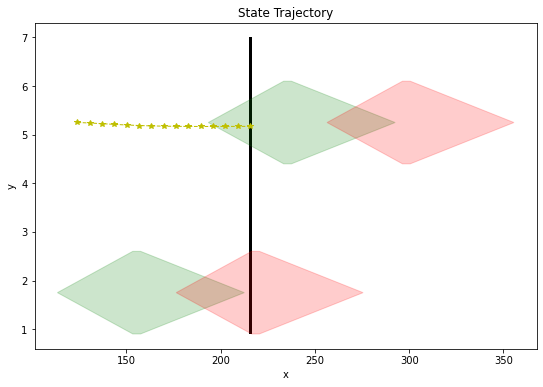

SV Lane Info :  [1, 1]
LV info :  [1, -1]
19 th step ended
---------------------------------------------------------------------
risk value :  0.6458877507559033


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


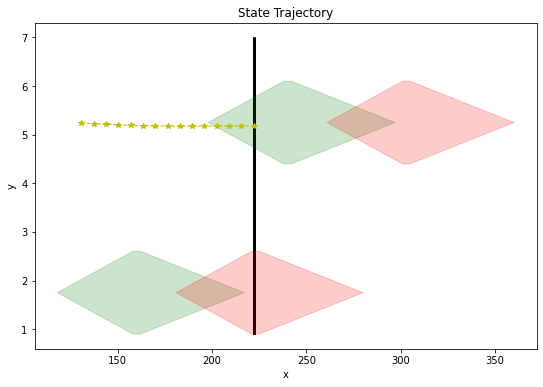

SV Lane Info :  [1, 1]
LV info :  [1, -1]
20 th step ended
---------------------------------------------------------------------
risk value :  0.6458174864660802


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


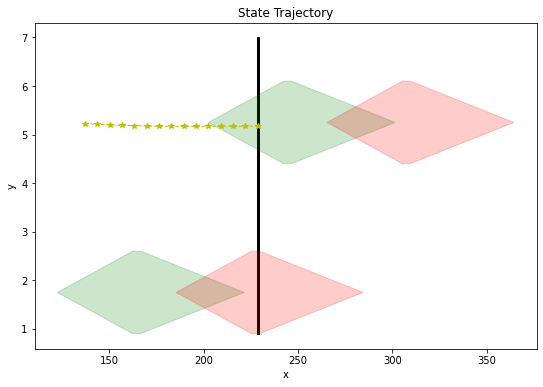

SV Lane Info :  [1, 1]
LV info :  [1, 0]
21 th step ended
---------------------------------------------------------------------
risk value :  0.6458296016489355


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


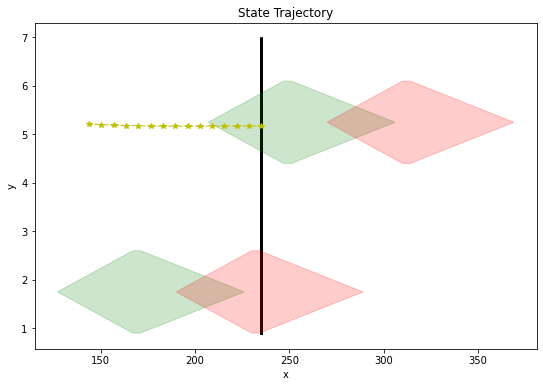

SV Lane Info :  [1, 1]
LV info :  [1, 0]
22 th step ended
---------------------------------------------------------------------
risk value :  0.6458447442222655


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


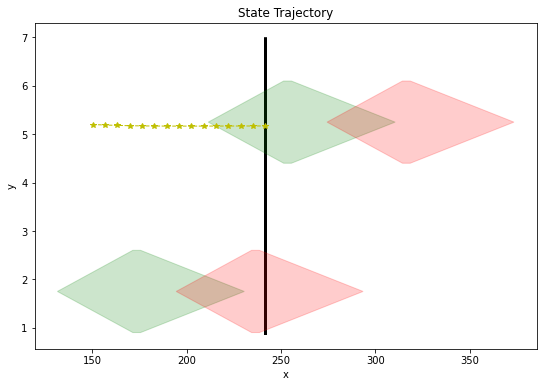

SV Lane Info :  [1, 1]
LV info :  [1, 0]
23 th step ended
---------------------------------------------------------------------
risk value :  0.6458243042566643


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


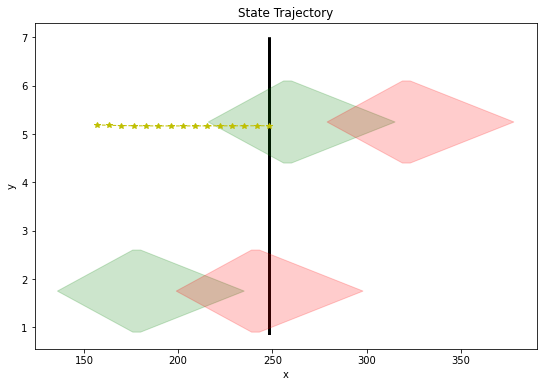

SV Lane Info :  [1, 1]
LV info :  [1, 0]
24 th step ended
---------------------------------------------------------------------
risk value :  0.6458322935888272


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


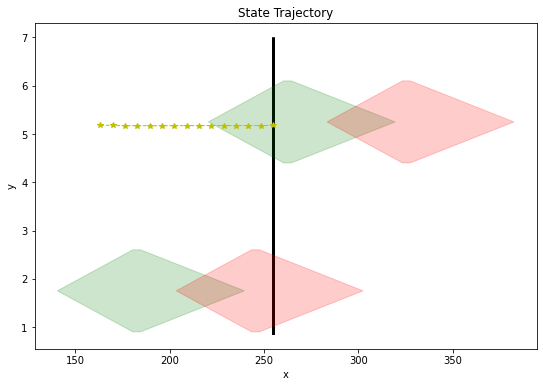

SV Lane Info :  [1, 1]
LV info :  [1, 0]
25 th step ended
---------------------------------------------------------------------
risk value :  0.6458268418560665


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


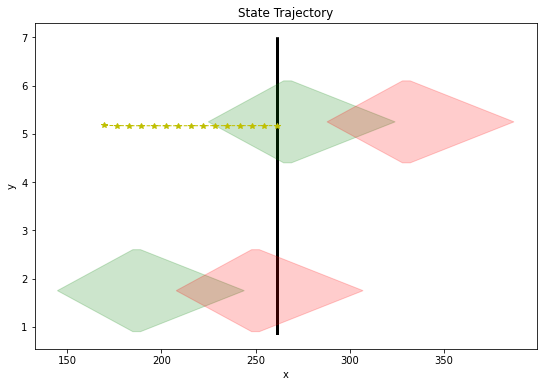

SV Lane Info :  [1, 1]
LV info :  [1, 0]
26 th step ended
---------------------------------------------------------------------
risk value :  0.6458789690278965


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


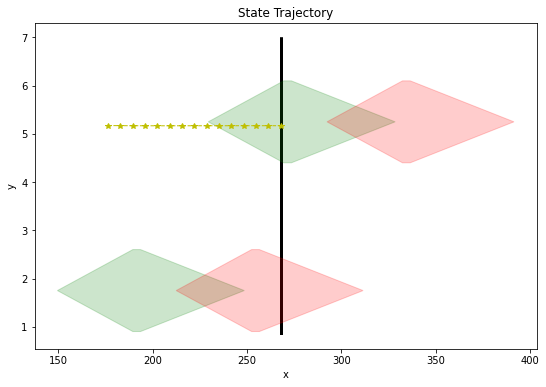

SV Lane Info :  [1, 1]
LV info :  [1, 0]
27 th step ended
---------------------------------------------------------------------
risk value :  0.6458838306386696


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


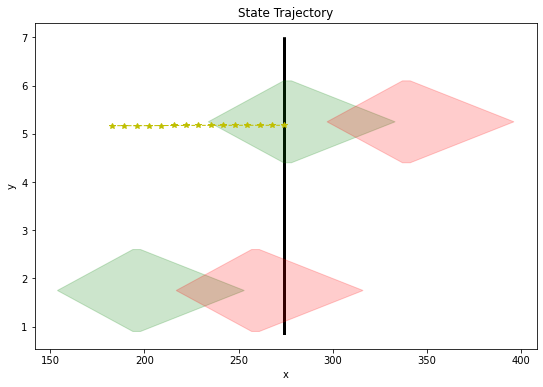

SV Lane Info :  [1, 1]
LV info :  [1, 0]
28 th step ended
---------------------------------------------------------------------
risk value :  0.6458856026966538


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


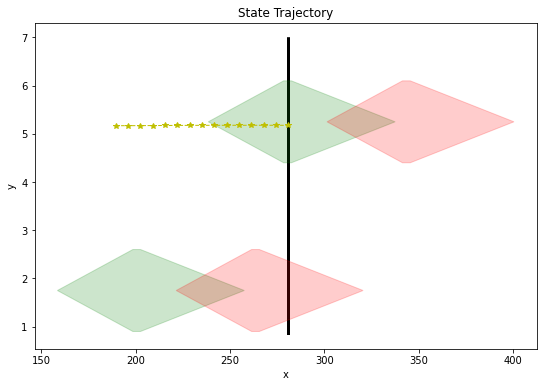

SV Lane Info :  [1, 1]
LV info :  [1, 0]
29 th step ended
---------------------------------------------------------------------
risk value :  0.6458953639444691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


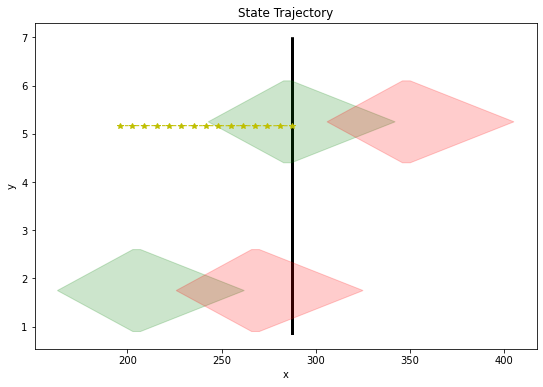

SV Lane Info :  [1, 1]
LV info :  [1, 0]
30 th step ended
---------------------------------------------------------------------
risk value :  0.645881426728095


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


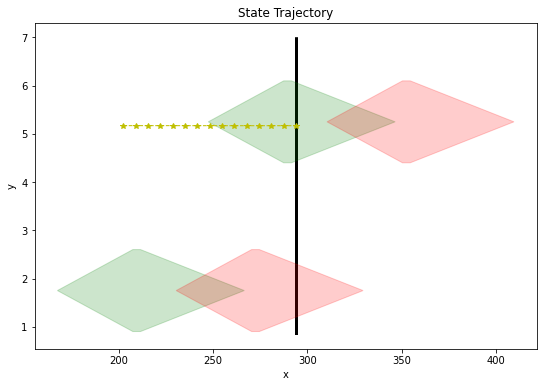

SV Lane Info :  [1, 1]
LV info :  [1, 0]
31 th step ended
---------------------------------------------------------------------
risk value :  0.6458785168832634


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


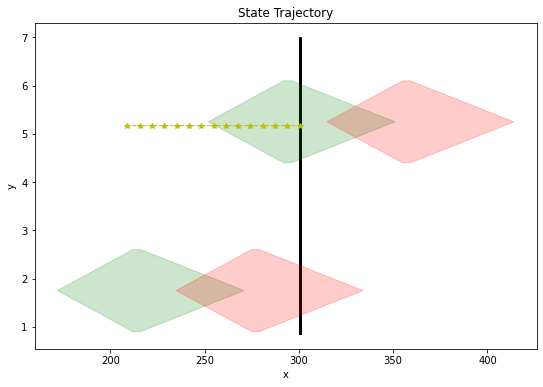

SV Lane Info :  [1, 1]
LV info :  [1, 0]
32 th step ended
---------------------------------------------------------------------
risk value :  0.6458815351808084


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


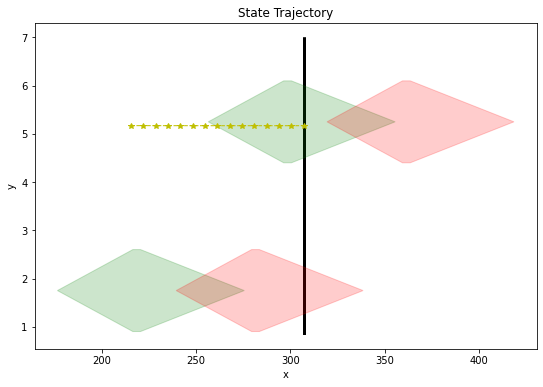

SV Lane Info :  [1, 1]
LV info :  [1, 0]
33 th step ended
---------------------------------------------------------------------
risk value :  0.645888227358521


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


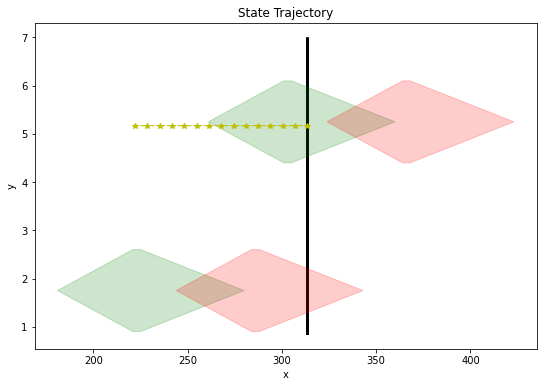

SV Lane Info :  [1, 1]
LV info :  [1, 0]
34 th step ended
---------------------------------------------------------------------
risk value :  0.645897465723563


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


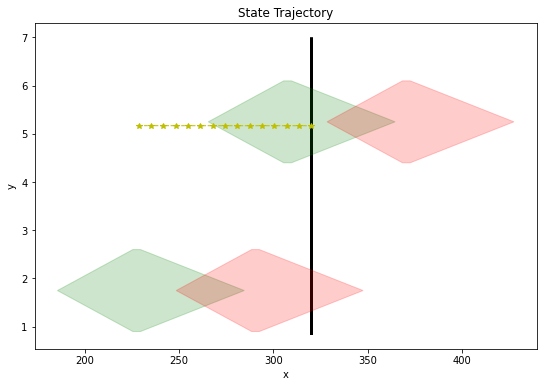

SV Lane Info :  [1, 1]
LV info :  [1, 0]
35 th step ended
---------------------------------------------------------------------
risk value :  0.6459069785581777


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


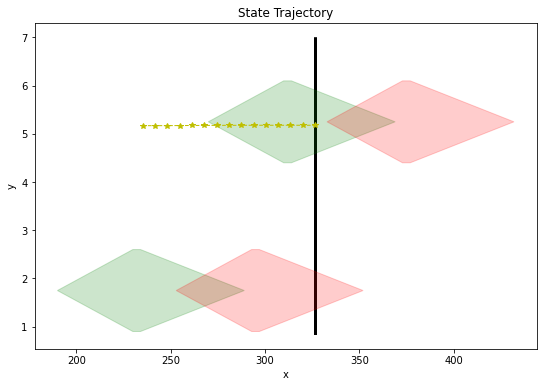

SV Lane Info :  [1, 1]
LV info :  [1, 0]
36 th step ended
---------------------------------------------------------------------
risk value :  0.6458817689812812


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


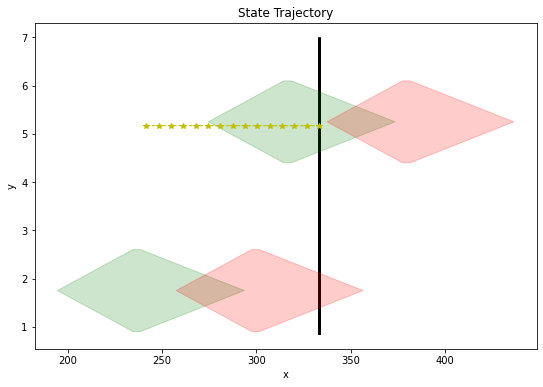

SV Lane Info :  [1, 1]
LV info :  [1, 0]
37 th step ended
---------------------------------------------------------------------
risk value :  0.6458725000915614


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


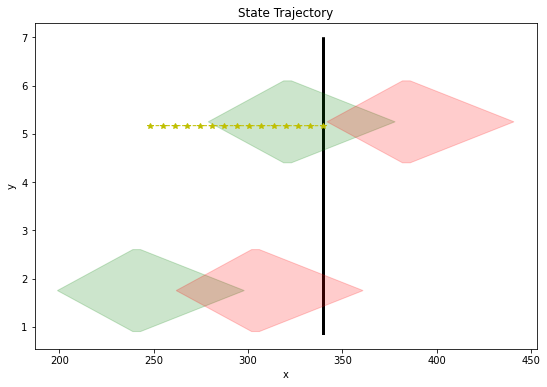

SV Lane Info :  [1, 1]
LV info :  [1, 0]
38 th step ended
---------------------------------------------------------------------
risk value :  0.6458716362271868


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


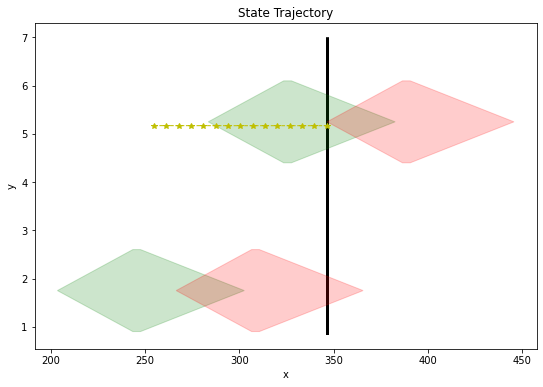

SV Lane Info :  [1, 1]
LV info :  [1, 0]
39 th step ended
---------------------------------------------------------------------
risk value :  0.6458754759491211


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


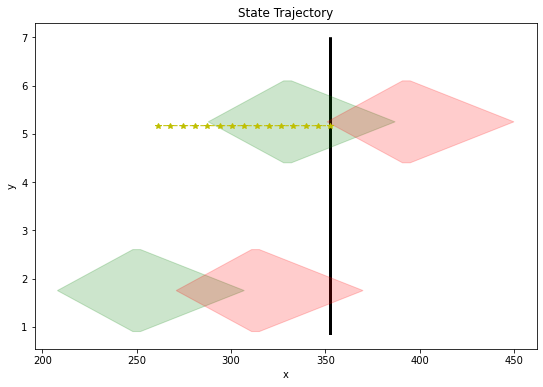

SV Lane Info :  [1, 1]
LV info :  [1, 0]
40 th step ended
---------------------------------------------------------------------
risk value :  0.6465697242328398


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


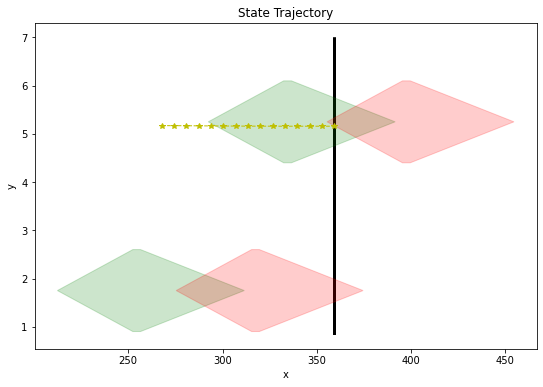

SV Lane Info :  [1, 1]
LV info :  [1, 0]
41 th step ended
---------------------------------------------------------------------
risk value :  0.6576636916748951


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


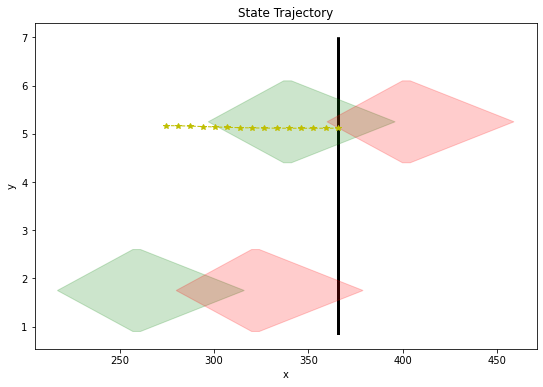

SV Lane Info :  [1, 1]
LV info :  [1, 0]
42 th step ended
---------------------------------------------------------------------
risk value :  0.6793849244668972


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


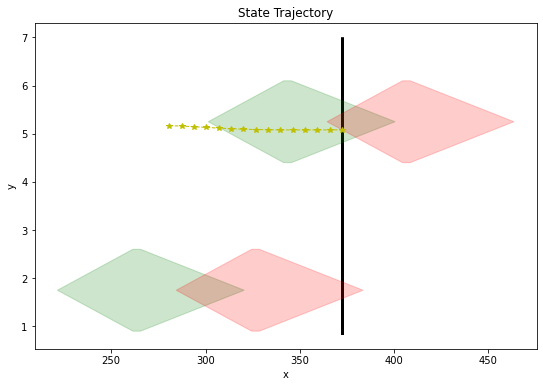

SV Lane Info :  [1, 1]
LV info :  [1, 0]
43 th step ended
---------------------------------------------------------------------
risk value :  0.666149653786879
Move from lane 1 to 2 . LV info :  1   0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


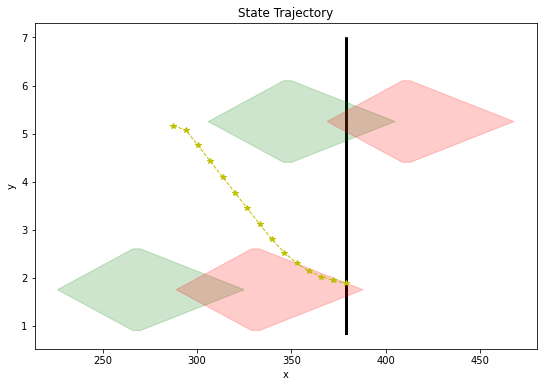

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[0.48396 0.42835 0.61414 0.802   0.98986 1.17772 1.36558 1.55344 1.73273
  1.87033 1.952   1.97705 1.95362 1.89516 1.81792]
 [2.82829 2.84603 2.62238 2.39666 2.17093 1.9452  1.71948 1.49376 1.2766
  1.10113 0.9816  0.91869 0.90425 0.92485 0.96422]]
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]]
44 th step ended
---------------------------------------------------------------------
risk value :  0.6513778728045183
Move from lane 1 to 2 . LV info :  1   0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


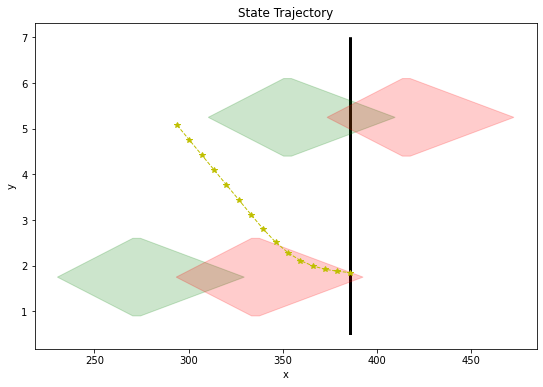

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[0.52399 0.70979 0.89765 1.08551 1.27337 1.46123 1.64909 1.82998 1.97513
  2.06609 2.09848 2.0771  2.01223 1.91715 1.80643]
 [2.77648 2.55282 2.32709 2.10137 1.87564 1.64991 1.42419 1.20543 1.02241
  0.89359 0.82333 0.80685 0.83385 0.89108 0.96392]]
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]]
45 th step ended
---------------------------------------------------------------------
risk value :  0.6463352722668614
Move from lane 1 to 2 . LV info :  1   0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


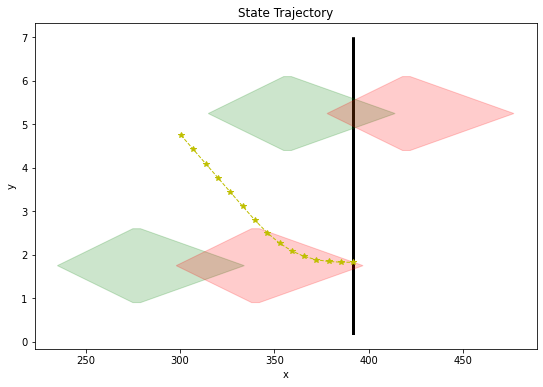

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[0.80543 0.99329 1.18115 1.36901 1.55687 1.74473 1.92698 2.07876 2.17888
  2.22056 2.20642 2.14459 2.04601 1.9228  1.78729]
 [2.4833  2.25757 2.03185 1.80612 1.5804  1.35467 1.13456 0.94491 0.80693
  0.72738 0.70366 0.72763 0.78834 0.87369 0.97132]]
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]]
46 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 1 to 2 . LV info :  1   0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


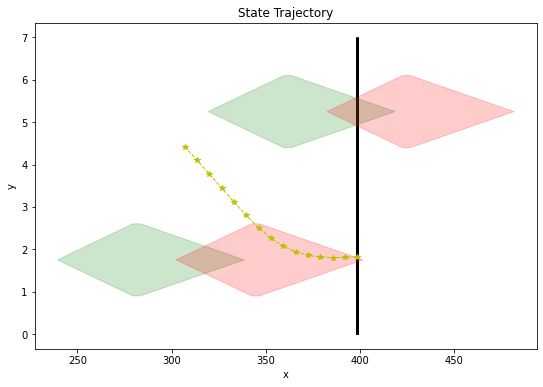

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[1.08894 1.2768  1.46466 1.65252 1.84038 2.02329 2.1785  2.2838  2.33155
  2.32344 2.26652 2.17041 2.04549 1.90196 1.74952]
 [2.18806 1.96233 1.7366  1.51088 1.28515 1.06437 0.8713  0.72813 0.64252
  0.61277 0.63182 0.69006 0.77712 0.88278 0.99736]]
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]]
47 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 1 to 2 . LV info :  1   0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


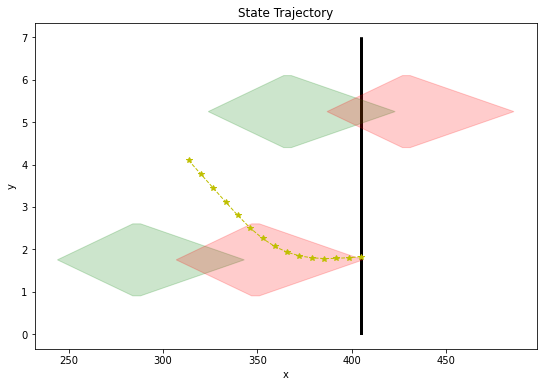

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[1.37244 1.5603  1.74816 1.93602 2.11917 2.27566 2.38323 2.43414 2.42991
  2.37728 2.28532 2.16354 2.02088 1.86529 1.70382]
 [1.89281 1.66709 1.44136 1.21564 0.99462 0.80027 0.65483 0.56606 0.53243
  0.54719 0.60128 0.6852  0.78999 0.90771 1.03132]]
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]]
48 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 1 to 2 . LV info :  1   0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


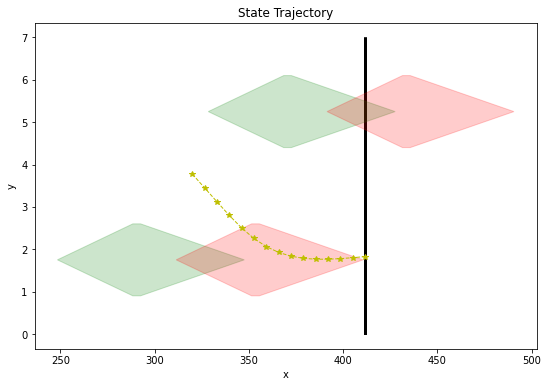

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[1.65594 1.8438  2.03167 2.21489 2.37183 2.48035 2.53283 2.53087 2.48125
  2.39294 2.27519 2.13642 1.98372 1.82287 1.65856]
 [1.59757 1.37185 1.14612 0.92503 0.73023 0.58384 0.4935  0.45759 0.46934
  0.51979 0.59967 0.70058 0.81541 0.9384  1.06484]]
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]]
49 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 1 to 2 . LV info :  1   0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


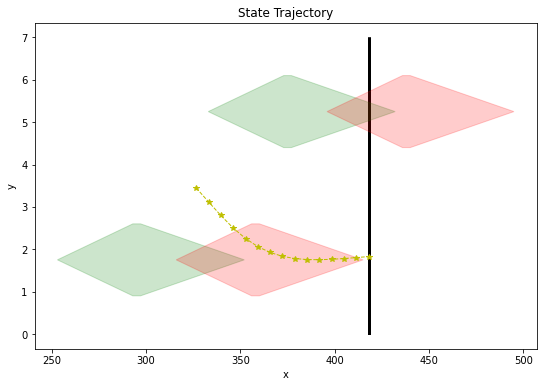

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[1.93945 2.12731 2.31053 2.46749 2.57619 2.62917 2.62818 2.58012 2.49406
  2.37929 2.24413 2.09543 1.93842 1.77694 1.61381]
 [1.30233 1.0766  0.85551 0.66069 0.51412 0.42328 0.3864  0.3966  0.44479
  0.5217  0.61899 0.72983 0.84898 0.97259 1.09786]]
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]]
50 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 1 to 2 . LV info :  1   0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


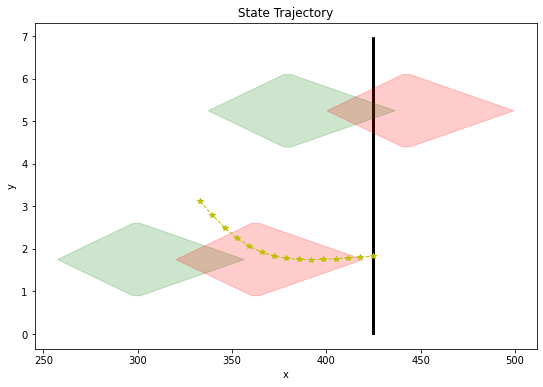

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.22295 2.40615 2.56298 2.67156 2.72451 2.72372 2.67621 2.59117 2.47801
  2.34515 2.19945 2.04607 1.88859 1.72928 1.56955]
 [1.00709 0.78602 0.59133 0.44489 0.35406 0.31699 0.32664 0.37381 0.44911
  0.5441  0.65194 0.76745 0.88707 1.00852 1.13038]]
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]]
51 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 1 to 2 . LV info :  1   0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


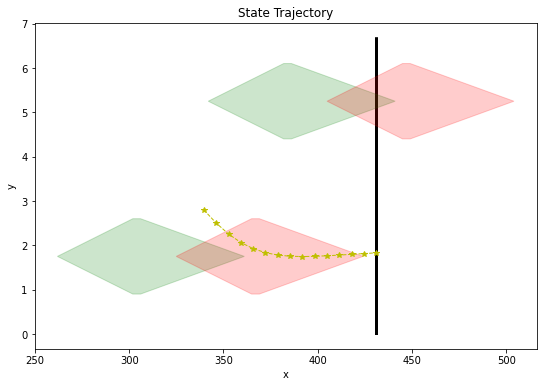

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.50179 2.65859 2.76703 2.81982 2.81889 2.77137 2.68657 2.57398 2.44217
  2.29811 2.14704 1.99256 1.83688 1.68112 1.5257 ]
 [0.71651 0.52184 0.37553 0.28489 0.24795 0.2576  0.30454 0.37926 0.47321
  0.57941 0.69261 0.80922 0.92704 1.04494 1.16249]]
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]]
52 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 1 to 2 . LV info :  1   0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


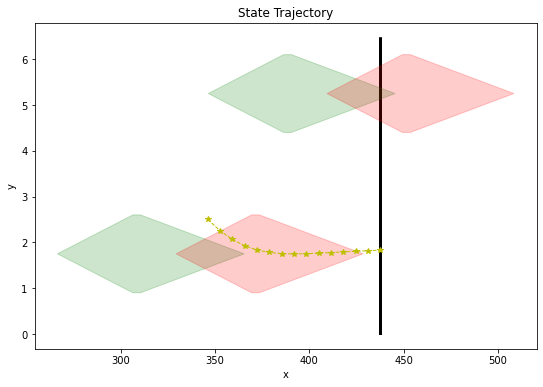

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.75424 2.86266 2.91531 2.9142  2.8665  2.78156 2.669   2.53744 2.39398
  2.24398 2.09115 1.93777 1.78502 1.63321 1.48216]
 [0.45231 0.30603 0.21551 0.17875 0.1886  0.23566 0.31036 0.40405 0.50965
  0.62179 0.73676 0.85227 0.96715 1.08109 1.19428]]
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]]
53 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 1 to 2 . LV info :  1   0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


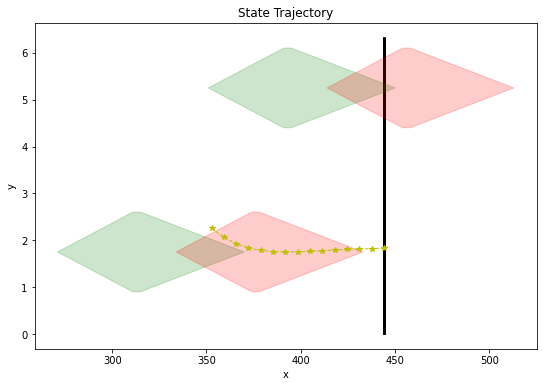

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.95831 3.01094 3.00972 2.96184 2.87671 2.76397 2.6323  2.48888 2.33914
  2.18693 2.03463 1.88352 1.73403 1.58598 1.43883]
 [0.23649 0.14599 0.10934 0.11936 0.16662 0.2415  0.3353  0.44086 0.55273
  0.66708 0.78152 0.89476 1.00639 1.11657 1.22586]]
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]]
54 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 1 to 2 . LV info :  1   0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


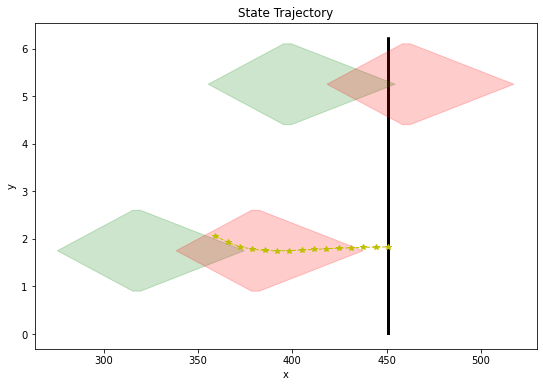

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[3.10659 3.10535 3.05738 2.97211 2.85918 2.72731 2.58372 2.4339  2.28173
  2.12971 1.97923 1.83081 1.68441 1.53957 1.39563]
 [0.07644 0.03981 0.04991 0.09733 0.17239 0.26639 0.37212 0.48408 0.59838
  0.71253 0.82515 0.9357  1.04424 1.15121 1.25729]]
[[False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]]
55 th step ended
---------------------------------------------------------------------
risk value :  0.6458671964406718
Move from lane 1 to 2 . LV info :  1   0
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
Model unknown

  Variables:
    x : Size=60, Index=x_index
        Key     : Lower : Value                  : Upper : Fixed : Stale : Domain
         (0, 0) :  None 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


        (0, 12) :  None :  -0.0029544505873816095 :  None : False : False :  Reals
        (0, 13) :  None :   -0.005110894269797298 :  None : False : False :  Reals
        (0, 14) :  None : -2.9829054346025514e-19 :  None : False : False :  Reals
         (1, 0) :  None :    0.020300848630290726 :  None : False : False :  Reals
         (1, 1) :  None :   -0.002804341070843039 :  None : False : False :  Reals
         (1, 2) :  None :  -0.0037156788268083033 :  None : False : False :  Reals
         (1, 3) :  None :   -0.003566443627563752 :  None : False : False :  Reals
         (1, 4) :  None :  -0.0025657436715316125 :  None : False : False :  Reals
         (1, 5) :  None :  -0.0018019410961099488 :  None : False : False :  Reals
         (1, 6) :  None :  -0.0013102531112643733 :  None : False : False :  Reals
         (1, 7) :  None :   -0.001003871825427018 :  None : False : False :  Reals
         (1, 8) :  None :  -0.0007979327276958024 :  None : False : False :  Reals
    

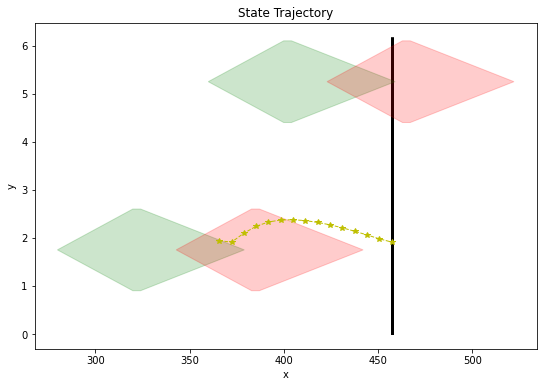

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[ 3.18427  3.07822  2.75194  2.46964  2.24111  2.06137  1.91659  1.7965
   1.69454  1.60657  1.52975  1.46193  1.40081  1.34195  1.27098]
 [-0.01302  0.05516  0.34358  0.58802  0.77868  0.92056  1.02748  1.1097
   1.1738   1.22392  1.26287  1.29283  1.31609  1.33709  1.37021]]
[[False False False False False False False False False False False False
  False False False]
 [ True False False False False False False False False False False False
  False False False]]
Feasiblilty :  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False False False False False False False False False False False False
 False False False False False False

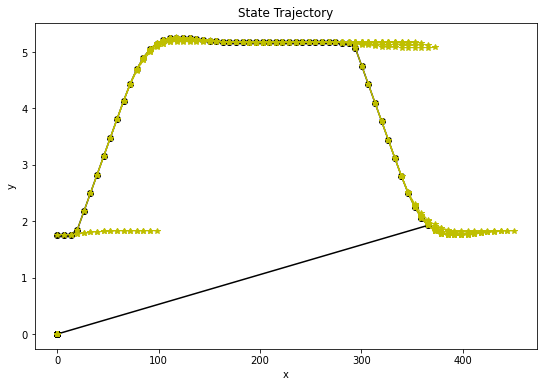

In [24]:
############ Initialize the system #################
U_safe = 0.68
sampling_time = 0.2
N = 14
SV = Subject_vehicle(SV_initial_x, SV_initial_y, SV_initial_psi)
LV1 = Lead_vehicle(LV_initialize[0,0], LV_initialize[1,0], LV_initialize[2,0])
LV2 = Lead_vehicle(LV_initialize[0,1], LV_initialize[1,1], LV_initialize[2,1])
LV3 = Lead_vehicle(LV_initialize[0,2], LV_initialize[1,2], LV_initialize[2,2])
LV_list = [LV1, LV2, LV3]
####################################################

# Q, R is defined above
# A = SV.A
# B = SV.B
P = np.eye(4)
x0 = SV.getState()
# xL = -15
# xU = 15
# uL = -1
# uU = 1
M = 90  # 165
feas = np.zeros((M), dtype=bool)
xOpt = np.zeros((np.size(SV.A,1), M+1))
xPred = np.zeros((3, N+1, M))
LV1_pos = np.zeros((2, M+1))
LV2_pos = np.zeros((2, M+1))
LV3_pos = np.zeros((2, M+1))
LV1_pos_pred = np.zeros((2, M+1))
LV2_pos_pred = np.zeros((2, M+1))
LV3_pos_pred = np.zeros((2, M+1))
target_point = np.zeros((3, M))

xOpt[:,0] = x0
LV1_pos[:,0] = LV1.getPosition()
LV2_pos[:,0] = LV2.getPosition()
LV3_pos[:,0] = LV3.getPosition()
LV1_pos_pred[:,0] = LV1.getPosition_predict()
LV2_pos_pred[:,0] = LV2.getPosition_predict()
LV3_pos_pred[:,0] = LV3.getPosition_predict()

uOpt = np.zeros((np.size(SV.B,1), M))
# predErr = np.zeros((2, M-N+1))
# xPred = np.zeros((2, N+1, M))

# TODO : obtain P
...

for t in range(M) :
  #### Get Target Point ####
  # Get meshgrid on the reachable set 
  # print(xOpt[:,:t+1])
  surround_LV_info = detect_LV(SV, LV_list)
  reachable_set = get_reachable_set(xOpt[0,t], xOpt[1,t], xOpt[2,t], xOpt[3,t], sampling_time, N)
  X = reachable_set.project([1,2])
  xx, yy = get_point_in_2D_bbox(reachable_set)
  
  # Make risk map
  risk_map = np.zeros((3,xx.size))
  index = 0
  for i in range(xx.shape[0]) :
    for j in range(xx.shape[1]) :
      risk_map[0,index] = xx[i,j]
      risk_map[1,index] = yy[i,j]
      risk_map[2,index] = risk_value(np.array([xx[i,j], yy[i,j]]), LV1, LV2, LV3, True) # modified : car_potential_off = True
      index += 1

  # Get target point from the risk map. The output is [x_target, y_target, risk_value]
  target_state = get_target_state(risk_map, xOpt[0,t])
  print('risk value : ', target_state[4])

  # Set Terminal Constraint - Af, bf. For now, our terminal constraint forces the system to go to x_target and y_target. (i.e. doesn't matter psi and v)
  # Af = np.array([[1.0,0,0,0], [-1.0,0,0,0], [0,1.0,0,0], [0,-1.0,0,0], 
                #  [0,0,1.0,0], [0,0,-1.0,0], [0,0,0,1.0], [0,0,0,-1.0]])
  Af = np.array([[1.0,0], [-1.0,0], [0,1.0], [0,-1.0]])
  bf = target_state[:4]

  [fea, x, u, J] = solve_cftoc_onlyCar(SV.A, SV.B, P, Q, R, N, xOpt[:,t], X_set, U_set, bf, Af, SV, surround_LV_info, LV_list, X, True)
  if not fea :
    # xOpt = []
    # uOpt = []
    break
  print(t,'th step ended')
  feas[t] = True
  xPred[:,:,t] = x[:3,:]
  SV.update_state_Notapprox(u[:,0])  # modified update_state_approx
  LV1.updatePosition()
  LV2.updatePosition()
  LV3.updatePosition()
  xOpt[:,t+1] = SV.getState()
  LV1_pos[:,t+1] = LV1.getPosition()
  LV2_pos[:,t+1] = LV2.getPosition()
  LV3_pos[:,t+1] = LV3.getPosition()
  LV1_pos_pred[:,t+1] = LV1.getPosition_predict()
  LV2_pos_pred[:,t+1] = LV2.getPosition_predict()
  LV3_pos_pred[:,t+1] = LV3.getPosition_predict()
  target_point[:,t] = [target_state[0], target_state[1], target_state[4]]
  uOpt[:,t] = u[:,0]
  print('---------------------------------------------------------------------')

print('Feasiblilty : ',feas)
print(xOpt)
print(uOpt)

fig = plt.figure(figsize=(9,6))
actual = plt.plot(xOpt[0,:], xOpt[1,:], 'ko-')
for t in range(np.size(xPred,2)) :
  pred = plt.plot(xPred[0,:,t], xPred[1,:,t], 'y*--', linewidth=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('State Trajectory')
plt.show()


[1, 1]
[-1, 0]
[[ 65.338    71.87093  78.40375  84.93645  91.46905  98.00154 104.53392
  111.06621 117.59838 124.13044 130.66238 137.19419 143.72587 150.25742
  156.78885 163.32015 169.85134 176.38241 182.91338 189.44423 195.97498
  202.50562 209.03616 215.56617 222.0923  228.61745 235.14248 241.6674
  248.19222 254.71694 261.24158 267.7665  274.29239 280.81939 287.34735
  293.87592 300.40481 306.93379 313.46275 319.99161 326.52037 333.04902
  339.57755 346.10599 352.63431]
 [  1.83      1.83      1.83      1.83      1.83      1.83      1.85
    1.9       1.94      1.98      2.03      2.07      2.11      2.15
    2.2       2.24      2.28      2.33207   2.36703   2.41151   2.4557
    2.49973   4.49367   4.72615   4.96749   4.99872   5.02993   5.06114
    5.09235   5.12355   5.15562   5.17795   5.1704    5.17288   5.17621
    5.17043   5.17083   5.16979   5.174     5.16954   5.17      5.17857
    5.17821   5.16958   5.17196]
 [  0.64587   0.64587   0.64587   0.64587   0.64587   0.64587  

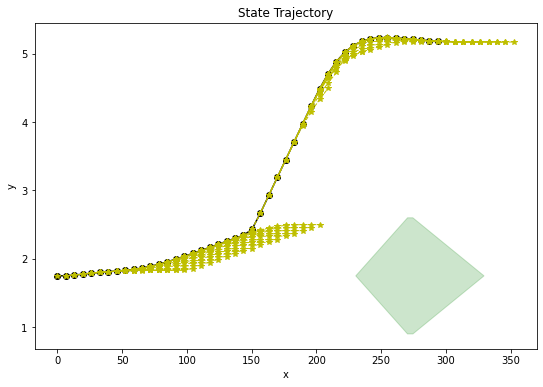

In [ ]:
print(SV.get_laneInfo())
print(detect_LV(SV, LV_list))
print(target_point)
wedge_LV1 = LV1.getWedgePoints()

fig = plt.figure(figsize=(9,6))
actual = plt.plot(xOpt[0,:], xOpt[1,:], 'ko-')
for t in range(np.size(xPred,2)) :
  pred = plt.plot(xPred[0,:,t], xPred[1,:,t], 'y*--', linewidth=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('State Trajectory')
plt.fill(wedge_LV1[:,0], wedge_LV1[:,1], alpha = 0.2, c = 'g')

plt.show()


(-80.0, 270.0)

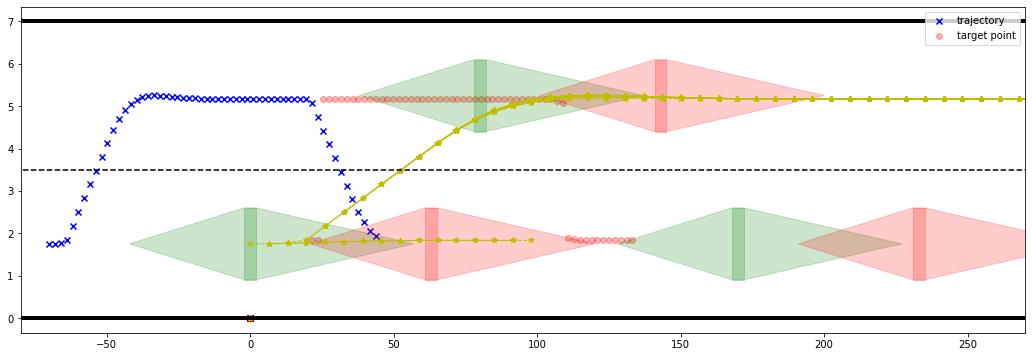

In [25]:
# print(xOpt)
# print(LV1_pos)
# print(LV2_pos)
# print(target_point)
# print(xOpt[0,:])
# print(LV1_pos[0,:])
# print(xOpt[0,:] - LV1_pos[0,:])

wedge_LV1 = LV1.getWedgePoints()
vertice_LV1 = wedge_LV1[[1,2,4,5],:]
wedge_LV2 = LV2.getWedgePoints()
vertice_LV2 = wedge_LV2[[1,2,4,5],:]
wedge_LV3 = LV3.getWedgePoints()
vertice_LV3 = wedge_LV3[[1,2,4,5],:]

wedge_LV1[:,0] = wedge_LV1[:,0] - LV1.getPosition()[0]
vertice_LV1[:,0] = vertice_LV1[:,0] - LV1.getPosition()[0]
wedge_LV2[:,0] = wedge_LV2[:,0] - LV1.getPosition()[0]
vertice_LV2[:,0] = vertice_LV2[:,0] - LV1.getPosition()[0]
wedge_LV3[:,0] = wedge_LV3[:,0] - LV1.getPosition()[0]
vertice_LV3[:,0] = vertice_LV3[:,0] - LV1.getPosition()[0]

##---- Predicted location ----##
wedge_predict_LV1 = LV1.getWedgePoints_predict()
vertice_predict_LV1 = wedge_predict_LV1[[1,2,4,5],:]
wedge_predict_LV2 = LV2.getWedgePoints_predict()
vertice_predict_LV2 = wedge_predict_LV2[[1,2,4,5],:]
wedge_predict_LV3 = LV3.getWedgePoints_predict()
vertice_predict_LV3 = wedge_predict_LV3[[1,2,4,5],:]

wedge_predict_LV1[:,0] = wedge_predict_LV1[:,0] - LV1.getPosition()[0]
vertice_predict_LV1[:,0] = vertice_predict_LV1[:,0] - LV1.getPosition()[0]
wedge_predict_LV2[:,0] = wedge_predict_LV2[:,0] - LV1.getPosition()[0]
vertice_predict_LV2[:,0] = vertice_predict_LV2[:,0] - LV1.getPosition()[0]
wedge_predict_LV3[:,0] = wedge_predict_LV3[:,0] - LV1.getPosition()[0]
vertice_predict_LV3[:,0] = vertice_predict_LV3[:,0] - LV1.getPosition()[0]
################################

fig, ax = plt.subplots(1,1, figsize=(18,6))
ax.scatter(xOpt[0,:] - LV1_pos[0,:], xOpt[1,:],  marker ='x', c = 'b')
ax.scatter(target_point[0,:] - LV1_pos[0,:-1], target_point[1,:], alpha = 0.3, marker ='o', c = 'r')
ax.legend(['trajectory', 'target point'])
for t in range(np.size(xPred,2)) :
  pred = plt.plot(xPred[0,:,t], xPred[1,:,t], 'y*--', linewidth=1)

ax.plot([-1000, 1000], [lane_width, lane_width], '--', c = 'k')
ax.plot([-1000, 1000], [2*lane_width, 2*lane_width], linewidth = 4, c = 'k')
ax.plot([-1000, 1000], [0, 0], linewidth = 4, c = 'k')
ax.fill(wedge_LV1[:,0], wedge_LV1[:,1], alpha = 0.2, c = 'g')
ax.fill(vertice_LV1[:,0], vertice_LV1[:,1], alpha = 0.2, c = 'g')
ax.fill(wedge_LV2[:,0], wedge_LV2[:,1], alpha = 0.2, c = 'g')
ax.fill(vertice_LV2[:,0], vertice_LV2[:,1], alpha = 0.2, c = 'g')
ax.fill(wedge_LV3[:,0], wedge_LV3[:,1], alpha = 0.2, c = 'g')
ax.fill(vertice_LV3[:,0], vertice_LV3[:,1], alpha = 0.2, c = 'g')

ax.fill(wedge_predict_LV1[:,0], wedge_predict_LV1[:,1], alpha = 0.2, c = 'r')
ax.fill(vertice_predict_LV1[:,0], vertice_predict_LV1[:,1], alpha = 0.2, c = 'r')
ax.fill(wedge_predict_LV2[:,0], wedge_predict_LV2[:,1], alpha = 0.2, c = 'r')
ax.fill(vertice_predict_LV2[:,0], vertice_predict_LV2[:,1], alpha = 0.2, c = 'r')
ax.fill(wedge_predict_LV3[:,0], wedge_predict_LV3[:,1], alpha = 0.2, c = 'r')
ax.fill(vertice_predict_LV3[:,0], vertice_predict_LV3[:,1], alpha = 0.2, c = 'r')

ax.set_xlim([xOpt[0,0] - LV1_pos[0,0] - 10, LV3.getPosition()[0] - LV1.getPosition()[0] + 100])

True


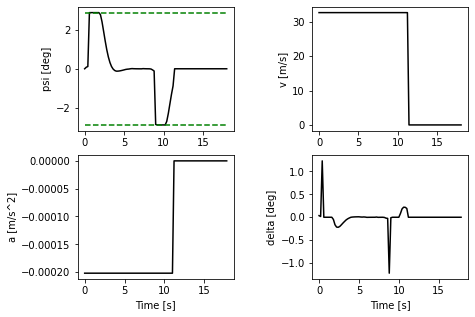

In [26]:
rad2deg = 180/np.pi
time = np.arange(0, M+1,1) * 0.2
fig, ax = plt.subplots(2,2, figsize = (7,5))
ax[0,0].plot(time, rad2deg * xOpt[2,:], 'k')
ax[0,0].plot(time, rad2deg * SV_psi_upper * np.ones(np.size(xOpt,1),), 'g--')
ax[0,0].plot(time, rad2deg * SV_psi_lower * np.ones(np.size(xOpt,1),), 'g--')
ax[0,1].plot(time, xOpt[3,:], 'k')
ax[1,0].plot(time[0:-1], uOpt[0,:], 'k')
ax[1,1].plot(time[0:-1], rad2deg * uOpt[1,:],'k')
fig.subplots_adjust(wspace=0.5)
ax[0,0].set_ylabel('psi [deg]')
ax[0,1].set_ylabel('v [m/s]')
ax[1,0].set_ylabel('a [m/s^2]')
ax[1,1].set_ylabel('delta [deg]')
ax[1,0].set_xlabel('Time [s]')
ax[1,1].set_xlabel('Time [s]')



# SV_psi_lower = -0.035
# SV_psi_upper = 0.035
# SV_v_lower = 22.5
# SV_v_upper = SV_v_desired

# SV_a_upper = 1.5 # [m/s^2]
# SV_a_lower = -1.5
# SV_delta_upper = 0.02 # [rad]
# SV_delta_lower = -0.02
print(xOpt[:,44] in X_set) 

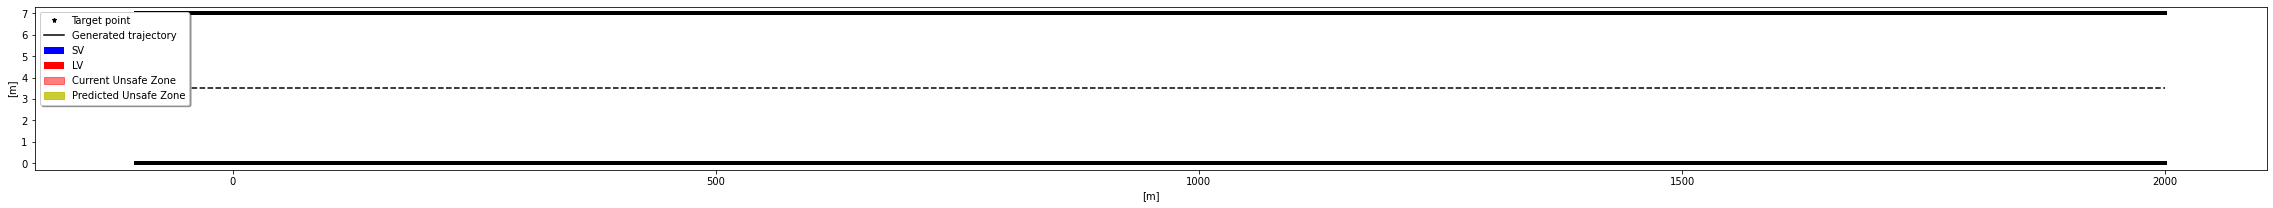

In [27]:
################## ANIMATION #####################
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# create a figure and axes
fig = plt.figure(figsize=(40,3))
ax1 = plt.subplot(1,1,1)   

# set up the subplots as needed
# ax1.set_xlim(( 0, 2))            
ax1.set_ylim((-0.3, num_lane*lane_width+0.3))
ax1.set_xlabel('[m]')
ax1.set_ylabel('[m]')

ax1.plot([-100, 2000], [lane_width, lane_width], '--', c = 'k')
ax1.plot([-100, 2000], [2*lane_width, 2*lane_width], linewidth = 4, c = 'k')
ax1.plot([-100, 2000], [0, 0], linewidth = 4, c = 'k')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
target_pt, = ax1.plot([], [], 'k*', ms=5)
traj_pred, = ax1.plot([], [], 'k', )
SV_anim, = ax1.fill([], [], 'b', lw=2)     # ax.plot returns a list of 2D line objects

LV1_anim, = ax1.fill([], [], 'r')
LV1_unsafe_anim, = ax1.fill([], [], alpha = 0.5, c='r')
LV1_pred_anim, = ax1.fill([], [], alpha=0.8, c='y')

LV2_anim, = ax1.fill([], [], 'r')
LV2_unsafe_anim, = ax1.fill([], [], alpha = 0.5, c='r')
LV2_pred_anim, = ax1.fill([], [], alpha=0.8, c='y')

LV3_anim, = ax1.fill([], [], 'r')
LV3_unsafe_anim, = ax1.fill([], [], alpha = 0.5, c='r')
LV3_pred_anim, = ax1.fill([], [], alpha=0.8, c='y')

ax1.legend([target_pt, traj_pred, SV_anim, LV1_anim, LV1_unsafe_anim, LV1_pred_anim],['Target point','Generated trajectory', 'SV', 'LV', 'Current Unsafe Zone', 'Predicted Unsafe Zone'],
           loc='upper left', shadow=True);

In [28]:
'''
xOpt = np.zeros((np.size(SV.A,1), M+1))
xPred = np.zeros((3, N+1, M))
LV1_pos = np.zeros((2, M+1))
LV2_pos = np.zeros((2, M+1))
LV3_pos = np.zeros((2, M+1))
LV1_pos_pred = np.zeros((2, M+1))
LV2_pos_pred = np.zeros((2, M+1))
LV3_pos_pred = np.zeros((2, M+1))
target_point = np.zeros((3, M))
'''

def SV_draw(state) :
  l_f = SV.l_f
  l_r = SV.l_r
  car_width=1.7
  x = state[0]
  y = state[1]
  psi = state[2]
  SV_vertice_x = np.array([[x + l_f*np.cos(psi) - car_width/2*np.sin(psi),
                           x - l_r*np.cos(psi) - car_width/2*np.sin(psi),
                           x - l_r*np.cos(psi) + car_width/2*np.sin(psi),
                           x + l_f*np.cos(psi) + car_width/2*np.sin(psi)]])
  SV_vertice_y = np.array([[y + l_f*np.sin(psi) + car_width/2*np.cos(psi),
                           y - l_r*np.sin(psi) + car_width/2*np.cos(psi),
                           y - l_r*np.sin(psi) - car_width/2*np.cos(psi),
                           y + l_f*np.sin(psi) - car_width/2*np.cos(psi)]])
  SV_vertice = np.concatenate((SV_vertice_x.T, SV_vertice_y.T), axis=1)

  return SV_vertice

print(SV_draw(xOpt[:,10]))
def drawframe(n):
  ax1.set_xlim((xOpt[0,n]-20, xOpt[0,n]+120))
  target_pt.set_data(target_point[0,n], target_point[1,n])
  traj_pred.set_data(xPred[0,:,n], xPred[1,:,n]) 
  SV_anim.set_xy(SV_draw(xOpt[:,n]))

  LV1_anim.set_xy(LV1.getVertice_anim(LV1_pos[:,n]))
  LV1_unsafe_anim.set_xy(LV1.getWedgePoints_anim(LV1_pos[:,n]))
  LV1_pred_anim.set_xy(LV1.getWedgePoints_anim(LV1_pos_pred[:,n]))

  LV2_anim.set_xy(LV2.getVertice_anim(LV2_pos[:,n]))
  LV2_unsafe_anim.set_xy(LV2.getWedgePoints_anim(LV2_pos[:,n]))
  LV2_pred_anim.set_xy(LV2.getWedgePoints_anim(LV2_pos_pred[:,n]))

  LV3_anim.set_xy(LV3.getVertice_anim(LV3_pos[:,n]))
  LV3_unsafe_anim.set_xy(LV3.getWedgePoints_anim(LV3_pos[:,n]))
  LV3_pred_anim.set_xy(LV3.getWedgePoints_anim(LV3_pos_pred[:,n]))

  txt_title.set_text('Time = {0:4f}s'.format(n*0.2))
  
  return (target_pt,traj_pred)

[[66.6855   5.04771]
 [63.76588  4.90708]
 [63.84767  3.20905]
 [66.76728  3.34968]]


In [30]:
from matplotlib import animation
from IPython.display import HTML

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=90, interval=300, blit=True)

HTML(anim.to_html5_video())

In [ ]:
'''
How to improve the model :
## Problem1 : Setting target point right behind of the front LV seems not reasonable intuitively 
## Problem2 : Since the cftoc design doesn't consider the risk map, the actual trajectory of SV intrudes unsafe zone of LVs. 

Here's idea to solve :
1) Problem1 : When calcuate car_potential value, let's consider predicted LV's configuration after ts*N sec (rather than considering the LV's configuration of when it was observed)
2) Problem2 : When solve cftoc, add constraint about x and y not to intrude the unsafe region. - But how?
                                                                                    - Need two information : LV in front of SV (Front obstacle), LV on the lane that SV will move to (Side obstacle) 
                                                                                    - May need three scenario : 1) changes lane (there's only Front obstacle) 2) after cross the middle line of the road, goes to steady state 
                                                                                                                3) changes lane (there are Front and Side obstacles) - refer to situation below. LV1 - Side obstacle, LV2 - Front 
                                                                                    
                                                                                    ==============================================================
                                                                                                 \   SV       \LV2
                                                                                    --------------\------------\-----------------------------------
                                                                                                LV1\          * \
                                                                                    ==============================================================
                                                                                    
                                                                                    - For each situation, constraint on x and y will be different
                                                                                    - Because extra constraints are added, X_f would better be larger
                                                                                    - For further scenario, 'there's no point whose risk value < U_safe' will be interesting
'''

In [ ]:
# UAV model
# Andrew, Thomas, Prachitesh

# def UAV_model():
v0 = 5
g = 9.81
m = 10
lx = 
ly =
lz =
# Matrices from paper
A = [(0,0,0,1,0,0,0,0,0,0,0),
     (0,0,0,0,1,0,0,0,0,0,0),
     (0,0,0,0,0,1,0,0,0,0,0),
     (0,0,0,0,0,0,0,-g,0,0,0),
     (0,0,0,0,0,0,g,0,0,0,0),
     (0,0,0,0,0,0,0,0,0,0,0),
     (0,0,0,0,0,0,0,0,1,0,0),
     (0,0,0,0,0,0,0,0,0,1,0),
     (0,0,0,0,0,0,0,0,0,0,1),
     (0,0,0,0,0,0,0,0,0,0,0),
     (0,0,0,0,0,0,0,0,0,0,0),
     (0,0,0,0,0,0,0,0,0,0,0)]

B = [(0,0,0,0),
     (0,0,0,0),
     (0,0,0,0),
     (0,0,0,0),
     (1.0/m,0,0,0),
     (0,0,0,0),
     (0,0,0,0),
     (0,0,0,0),
     (0,0,0,0),
     (0,1.0/lx,0,0),
     (0,0,1.0/ly,0),
     (0,0,0,1.0/lz)]

A = [(v0)]

# Note: need constraints on roll, pitch, yaw angles to keep small



SyntaxError: ignored

In [ ]:
import polytope as pt
import numpy as np
from __future__ import division
import pyomo.environ as pyo
import matplotlib.pyplot as plt
# %matplotlib widget

In [ ]:
# MPC, general problem from lab 8

# Things to define: A, B, P, Q, R, N, x0, xL, xU, uL, uU

# TO BE FILLED IN:
A = np.array([[1, 1],
               [0, 1]])
B = np.array([[0],
              [1]])

Q = np.eye(2)
R = 10*np.array([1]).reshape(1,1)
P = Q
N = 3
xL = -5
xU = 5
uL = -0.5
uU = 0.5
x0 = np.array([-4.5, 2])
# END OF TO BE FILLED IN SECTION


bf=np.nan
Af=np.nan

model = pyo.ConcreteModel()
model.N = N
model.nx = np.size(A, 0)
model.nu = np.size(B, 1)

# length of finite optimization problem:
model.tIDX = pyo.Set( initialize= range(model.N+1), ordered=True )  
model.xIDX = pyo.Set( initialize= range(model.nx), ordered=True )
model.uIDX = pyo.Set( initialize= range(model.nu), ordered=True )

# these are 2d arrays:
model.A = A
model.B = B
model.Q = Q
model.P = P
model.R = R

# Create state and input variables trajectory:
model.x = pyo.Var(model.xIDX, model.tIDX, bounds=(xL,xU))
model.u = pyo.Var(model.uIDX, model.tIDX, bounds=(uL,uU))

#Objective:
def objective_rule(model):
    costX = 0.0
    costU = 0.0
    costTerminal = 0.0
    for t in model.tIDX:
        for i in model.xIDX:
            for j in model.xIDX:
                if t < model.N:
                    costX += model.x[i, t] * model.Q[i, j] * model.x[j, t] 
    for t in model.tIDX:
        for i in model.uIDX:
            for j in model.uIDX:
                if t < model.N:
                    costU += model.u[i, t] * model.R[i, j] * model.u[j, t]
    for i in model.xIDX:
        for j in model.xIDX:               
            costTerminal += model.x[i, model.N] * model.P[i, j] * model.x[j, model.N]
    return costX + costU + costTerminal

model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)

# Constraints:
def equality_const_rule(model, i, t):
    return model.x[i, t+1] - (sum(model.A[i, j] * model.x[j, t] for j in model.xIDX)
                            +  sum(model.B[i, j] * model.u[j, t] for j in model.uIDX) ) == 0.0 if t < model.N else pyo.Constraint.Skip

model.equality_constraints = pyo.Constraint(model.xIDX, model.tIDX, rule=equality_const_rule)
model.init_const1 = pyo.Constraint(expr = model.x[0, 0] == x0[0])
model.init_const2 = pyo.Constraint(expr = model.x[1, 0] == x0[1])
    
solver = pyo.SolverFactory('ipopt')
results = solver.solve(model)

if str(results.solver.termination_condition) == "optimal":
    feas = True
else:
    feas = False
        
xOpt = np.asarray([[model.x[i,t]() for i in model.xIDX] for t in model.tIDX]).T
uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T

JOpt = model.cost()
  

